
Table: Heuristic scenarios (peak i, final size 1-s(T))
  No intervention     peak_i= 0.3180  final_size= 0.9937
  Vaccination only    peak_i= 0.1823  final_size= 1.0000
  Suppression only    peak_i= 0.2190  final_size= 0.9476
  Combined            peak_i= 0.1105  final_size= 1.0000

Table: Time-varying schedules (peak i, final size 1-s(T))
  Schedule #1 (Strong Early)  peak_i= 0.1105  final_size= 1.0000
  Schedule #2 (Ramp Up)       peak_i= 0.3032  final_size= 1.0000

Solving penalized optimal control (P_kappa,T) with PMP / FBS ...
[FBS] iter=  1  J= 6.155453  |du|_inf=1.250e-02  |dh|_inf=5.000e-02  |dJ|=inf
[FBS] iter= 10  J= 2.401658  |du|_inf=9.386e-04  |dh|_inf=3.135e-02  |dJ|=3.465e-02
[FBS] iter= 20  J= 2.315515  |du|_inf=9.452e-05  |dh|_inf=8.138e-03  |dJ|=1.450e-03
[FBS] iter= 30  J= 2.311704  |du|_inf=1.192e-05  |dh|_inf=9.046e-04  |dJ|=6.491e-05
[FBS] iter= 40  J= 2.311535  |du|_inf=1.064e-06  |dh|_inf=7.403e-05  |dJ|=2.830e-06
[FBS] iter= 50  J= 2.311528  |du|_inf=8.180e-08

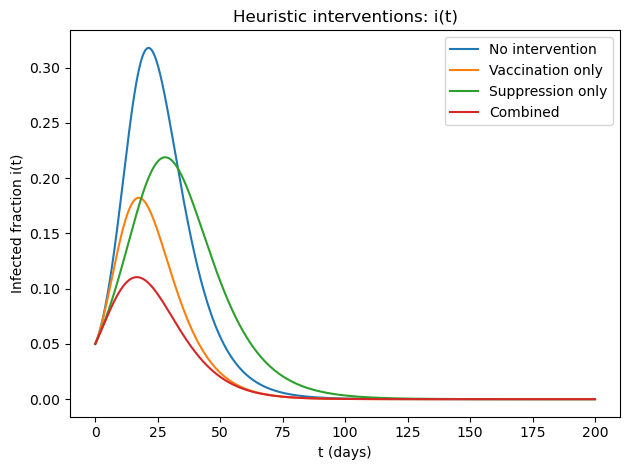

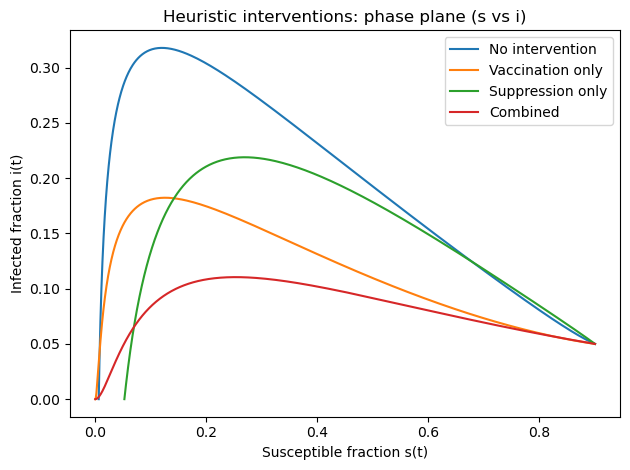

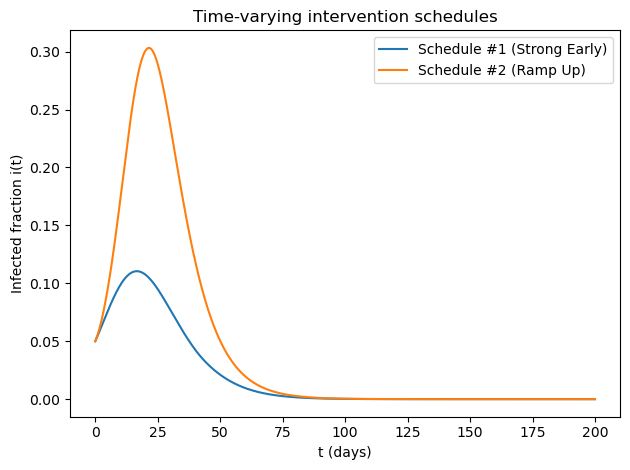

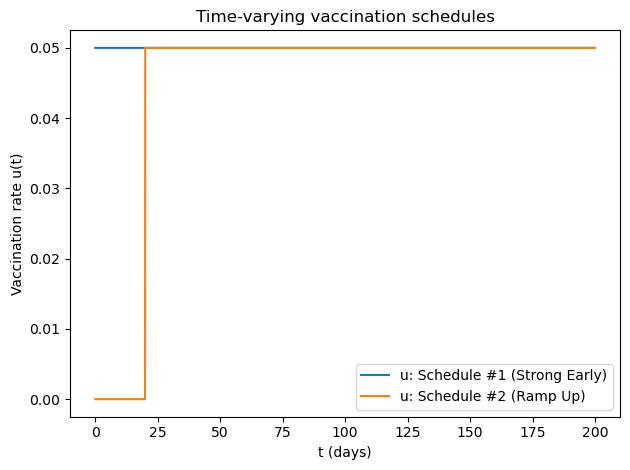

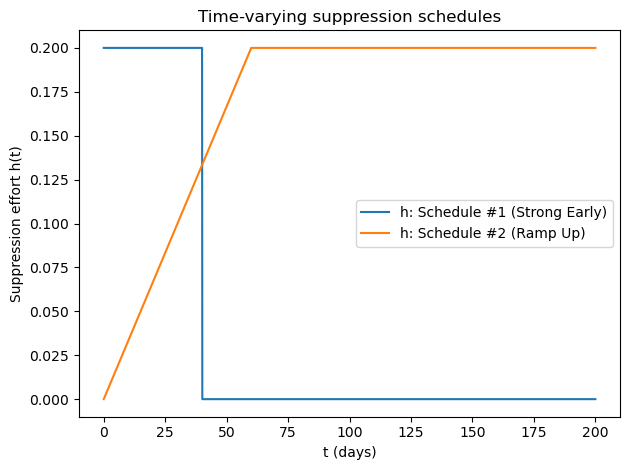

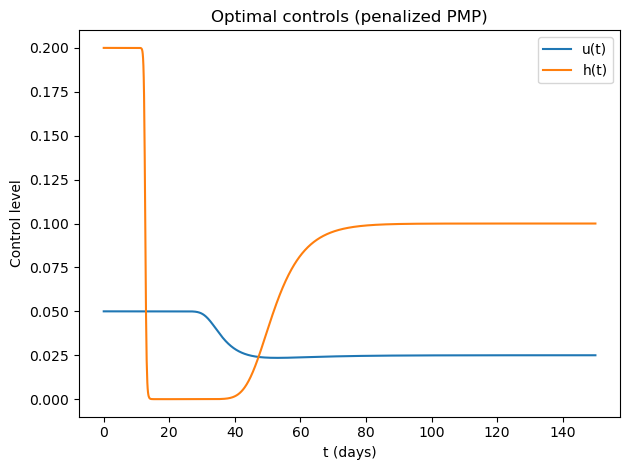

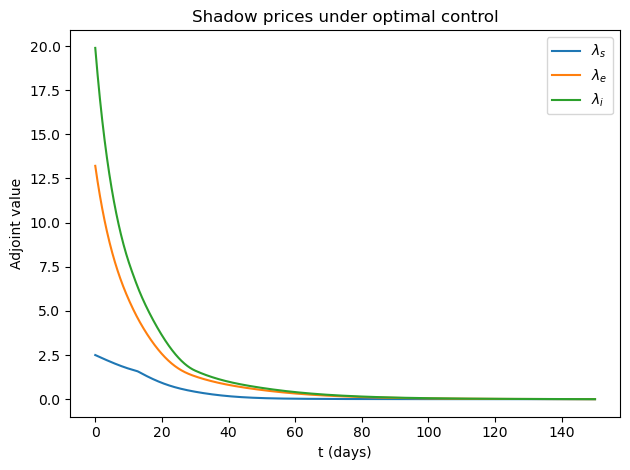

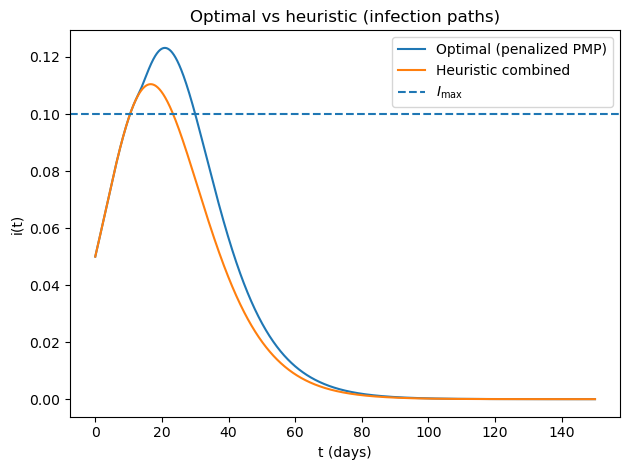

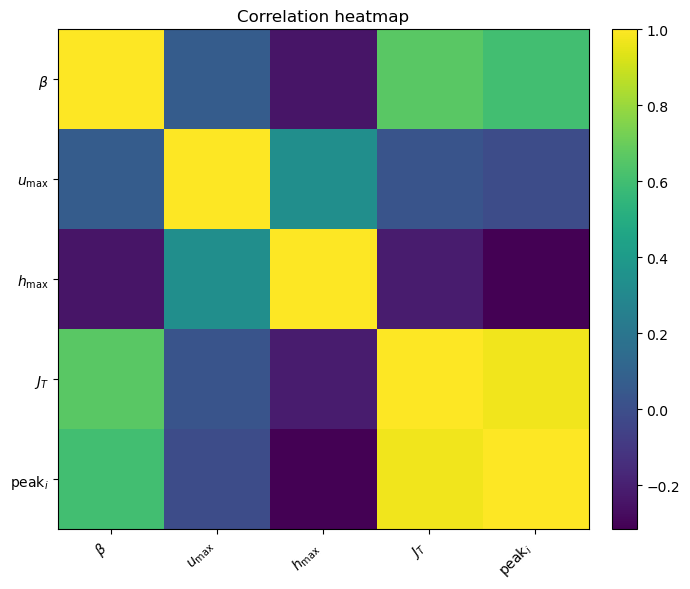

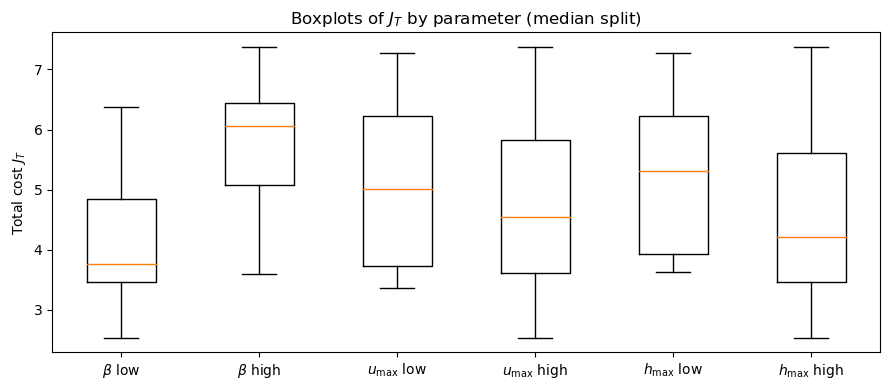

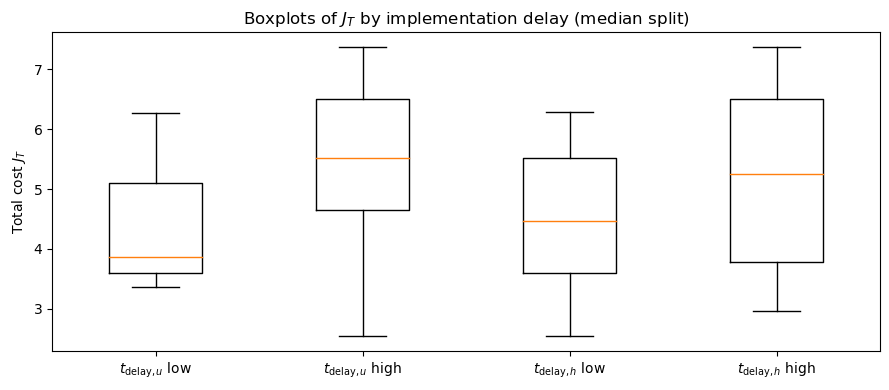

In [1]:
"""
SEIR controlled simulations + penalized optimal control (finite horizon)
- Heuristic scenario comparison
- Time-varying schedules
- Penalized PMP (forward-backward sweep) with discounting and capacity penalty
- Sensitivity: correlation heatmap + boxplots

Dependencies: numpy, matplotlib
Run: python seir_control.py
"""

import numpy as np
import matplotlib.pyplot as plt


# -----------------------------
# Utilities
# -----------------------------
def pospart(x):
    return np.maximum(0.0, x)


def clip01(x):
    return np.minimum(1.0, np.maximum(0.0, x))


def logistic(z):
    # stable logistic
    z = np.clip(z, -60.0, 60.0)
    return 1.0 / (1.0 + np.exp(-z))


def trapz(y, t):
    return np.trapz(y, t)


# -----------------------------
# Model + cost
# -----------------------------
class Params:
    def __init__(
        self,
        beta=0.5,
        sigma=0.2,
        gamma=0.1,
        I_max=0.1,
        u_max=0.05,
        h_max=0.2,
        t_delay_u=0.0,
        t_delay_h=0.0,
        # Costs + discount + penalty
        c_H=2.0,
        c_NH=1.0,
        c_V=1.0,
        delta=0.05,
        kappa=10.0,
    ):
        self.beta = float(beta)
        self.sigma = float(sigma)
        self.gamma = float(gamma)
        self.I_max = float(I_max)
        self.u_max = float(u_max)
        self.h_max = float(h_max)
        self.t_delay_u = float(t_delay_u)
        self.t_delay_h = float(t_delay_h)

        self.c_H = float(c_H)
        self.c_NH = float(c_NH)
        self.c_V = float(c_V)
        self.delta = float(delta)
        self.kappa = float(kappa)


def f_state(x, u, h, p: Params):
    """
    Reduced state x=(s,e,i). r is redundant.
    Dynamics:
      s' = -(beta-h) s i - u s
      e' = (beta-h) s i - sigma e
      i' = sigma e - gamma i
    """
    s, e, i = x
    beta_eff = p.beta - h
    ds = -(beta_eff) * s * i - u * s
    de = (beta_eff) * s * i - p.sigma * e
    di = p.sigma * e - p.gamma * i
    return np.array([ds, de, di], dtype=float)


def running_cost(t, x, u, h, p: Params):
    """
    l_kappa(t,x,u,h) = ( L0 + kappa*(max(0,i-Imax))^2 ) * exp(-delta t)
    L0 = c_H i h + c_NH i + c_V u s
    """
    s, e, i = x
    L0 = p.c_H * i * h + p.c_NH * i + p.c_V * u * s
    penalty = p.kappa * (pospart(i - p.I_max) ** 2)
    return (L0 + penalty) * np.exp(-p.delta * t)


def adjoint_rhs(t, x, lam, u, h, p: Params):
    """
    Costate equations (finite horizon, terminal condition lam(T)=0):
      lam_s' = -c_V u e^{-δt} + lam_s((β-h)i+u) - lam_e(β-h)i
      lam_e' = σ(lam_e - lam_i)
      lam_i' = -[c_H h + c_NH + 2κ(i-Imax)_+] e^{-δt} + (lam_s-lam_e)(β-h)s + γ lam_i
    """
    s, e, i = x
    lam_s, lam_e, lam_i = lam
    beta_eff = p.beta - h
    disc = np.exp(-p.delta * t)

    dlam_s = -p.c_V * u * disc + lam_s * (beta_eff * i + u) - lam_e * (beta_eff * i)
    dlam_e = p.sigma * (lam_e - lam_i)
    dlam_i = (
        -(p.c_H * h + p.c_NH + 2.0 * p.kappa * pospart(i - p.I_max)) * disc
        + (lam_s - lam_e) * beta_eff * s
        + p.gamma * lam_i
    )
    return np.array([dlam_s, dlam_e, dlam_i], dtype=float)


# -----------------------------
# RK4 integrators (from scratch)
# -----------------------------
def rk4_forward_step(x, t, dt, u, h, p: Params):
    k1 = f_state(x, u, h, p)
    k2 = f_state(x + 0.5 * dt * k1, u, h, p)
    k3 = f_state(x + 0.5 * dt * k2, u, h, p)
    k4 = f_state(x + dt * k3, u, h, p)
    xn = x + (dt / 6.0) * (k1 + 2 * k2 + 2 * k3 + k4)

    # light projection to avoid numerical drift
    xn = np.maximum(xn, 0.0)
    tot = xn.sum()
    if tot > 1.0:
        xn = xn / tot  # keep in simplex for (s,e,i); r=1-tot
    return xn


def rk4_backward_step(lam, t, dt, x, u, h, p: Params):
    """
    Backward integration: lam(t-dt) from lam(t).
    Equivalent to forward integration with negative dt.
    """
    k1 = adjoint_rhs(t, x, lam, u, h, p)
    k2 = adjoint_rhs(t - 0.5 * dt, x, lam - 0.5 * dt * k1, u, h, p)
    k3 = adjoint_rhs(t - 0.5 * dt, x, lam - 0.5 * dt * k2, u, h, p)
    k4 = adjoint_rhs(t - dt, x, lam - dt * k3, u, h, p)
    lam_prev = lam - (dt / 6.0) * (k1 + 2 * k2 + 2 * k3 + k4)
    return lam_prev


# -----------------------------
# Heuristic simulations
# -----------------------------
def simulate_with_control_functions(x0, p: Params, T=200.0, dt=0.1, control_fn=None):
    n = int(np.floor(T / dt)) + 1
    t = np.linspace(0.0, T, n)
    x = np.zeros((n, 3), dtype=float)
    u = np.zeros(n, dtype=float)
    h = np.zeros(n, dtype=float)

    x[0] = np.array(x0, dtype=float)

    for k in range(n - 1):
        tk = t[k]
        uk, hk = control_fn(tk, x[k]) if control_fn is not None else (0.0, 0.0)

        # enforce bounds + delays
        if tk < p.t_delay_u:
            uk = 0.0
        if tk < p.t_delay_h:
            hk = 0.0

        uk = float(np.clip(uk, 0.0, p.u_max))
        hk = float(np.clip(hk, 0.0, p.h_max))

        u[k] = uk
        h[k] = hk
        x[k + 1] = rk4_forward_step(x[k], tk, dt, uk, hk, p)

    # last control values (for plotting)
    u[-1], h[-1] = u[-2], h[-2]
    r = 1.0 - x.sum(axis=1)
    return t, x, r, u, h


def summarize_run(t, x):
    s = x[:, 0]
    i = x[:, 2]
    peak_i = float(np.max(i))
    final_size = float(1.0 - s[-1])  # final epidemic size proxy
    return peak_i, final_size


# -----------------------------
# PMP optimal control (FBS)
# -----------------------------
def solve_optimal_control_fbs(
    x0,
    p: Params,
    T=150.0,
    dt=0.1,
    max_iter=250,
    tol=1e-6,
    relax=0.2,
    smooth_eps=2e-3,
    verbose=True,
):
    """
    Forward-backward sweep for penalized finite-horizon PMP.
    Controls updated using smoothed bang-bang:
      u_bar = u_max * sigmoid( -Phi_u / eps )
      h_bar = h_max * sigmoid( -Phi_h / eps )
    then relaxation:
      u <- (1-relax)*u + relax*u_bar
    """
    n = int(np.floor(T / dt)) + 1
    t = np.linspace(0.0, T, n)

    # initialize controls
    u = np.zeros(n, dtype=float)
    h = np.zeros(n, dtype=float)

    # initialize states + adjoints
    x = np.zeros((n, 3), dtype=float)
    lam = np.zeros((n, 3), dtype=float)

    def compute_objective(tt, xx, uu, hh):
        vals = np.array([running_cost(tt[k], xx[k], uu[k], hh[k], p) for k in range(n)])
        return float(trapz(vals, tt))

    J_prev = np.inf

    for it in range(1, max_iter + 1):
        # 1) forward state
        x[0] = np.array(x0, dtype=float)
        for k in range(n - 1):
            tk = t[k]
            uk = u[k]
            hk = h[k]
            # enforce delays
            if tk < p.t_delay_u:
                uk = 0.0
            if tk < p.t_delay_h:
                hk = 0.0
            x[k + 1] = rk4_forward_step(x[k], tk, dt, uk, hk, p)

        # 2) backward adjoint
        lam[-1] = np.zeros(3, dtype=float)  # transversality
        for k in range(n - 1, 0, -1):
            tk = t[k]
            # use controls at index k (piecewise constant over [t_{k-1},t_k])
            uk = u[k]
            hk = h[k]
            # enforce delays
            if tk < p.t_delay_u:
                uk = 0.0
            if tk < p.t_delay_h:
                hk = 0.0
            lam[k - 1] = rk4_backward_step(lam[k], tk, dt, x[k], uk, hk, p)

        # 3) update controls from switching functions
        disc = np.exp(-p.delta * t)
        Phi_u = x[:, 0] * (p.c_V * disc - lam[:, 0])
        Phi_h = x[:, 2] * (p.c_H * disc + x[:, 0] * (lam[:, 0] - lam[:, 1]))

        # smoothed minimizer of affine Hamiltonian
        u_bar = p.u_max * logistic((-Phi_u) / smooth_eps)
        h_bar = p.h_max * logistic((-Phi_h) / smooth_eps)

        # enforce delays exactly
        u_bar = np.where(t < p.t_delay_u, 0.0, u_bar)
        h_bar = np.where(t < p.t_delay_h, 0.0, h_bar)

        # relaxation
        u_new = (1.0 - relax) * u + relax * u_bar
        h_new = (1.0 - relax) * h + relax * h_bar

        # bounds
        u_new = np.clip(u_new, 0.0, p.u_max)
        h_new = np.clip(h_new, 0.0, p.h_max)

        # convergence check
        du = np.max(np.abs(u_new - u))
        dh = np.max(np.abs(h_new - h))
        u, h = u_new, h_new

        J = compute_objective(t, x, u, h)
        dJ = abs(J_prev - J) if np.isfinite(J_prev) else np.inf
        J_prev = J

        if verbose and (it == 1 or it % 10 == 0):
            print(f"[FBS] iter={it:3d}  J={J: .6f}  |du|_inf={du:.3e}  |dh|_inf={dh:.3e}  |dJ|={dJ:.3e}")

        if max(du, dh) < tol and dJ < 1e-8:
            if verbose:
                print(f"[FBS] converged at iter={it}  J={J:.6f}")
            break

    r = 1.0 - x.sum(axis=1)
    return t, x, r, u, h, lam, J_prev


# -----------------------------
# Plots
# -----------------------------
def plot_intervention_comparison(t, runs, title_prefix="Heuristic interventions"):
    """
    runs: dict name -> (x,u,h)
    Produces:
      - i(t) time paths
      - phase plane s vs i
    """
    plt.figure()
    for name, (x, u, h) in runs.items():
        plt.plot(t, x[:, 2], label=name)
    plt.xlabel("t (days)")
    plt.ylabel("Infected fraction i(t)")
    plt.title(f"{title_prefix}: i(t)")
    plt.legend()
    plt.tight_layout()
    plt.savefig("fig_interventions_i.png", dpi=200)

    plt.figure()
    for name, (x, u, h) in runs.items():
        plt.plot(x[:, 0], x[:, 2], label=name)
    plt.xlabel("Susceptible fraction s(t)")
    plt.ylabel("Infected fraction i(t)")
    plt.title(f"{title_prefix}: phase plane (s vs i)")
    plt.legend()
    plt.tight_layout()
    plt.savefig("fig_interventions_phase.png", dpi=200)


def plot_time_varying(t, runs, title="Time-varying schedules"):
    plt.figure()
    for name, (x, u, h) in runs.items():
        plt.plot(t, x[:, 2], label=name)
    plt.xlabel("t (days)")
    plt.ylabel("Infected fraction i(t)")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.savefig("fig_time_varying_i.png", dpi=200)

    plt.figure()
    for name, (x, u, h) in runs.items():
        plt.plot(t, u, label=f"u: {name}")
    plt.xlabel("t (days)")
    plt.ylabel("Vaccination rate u(t)")
    plt.title("Time-varying vaccination schedules")
    plt.legend()
    plt.tight_layout()
    plt.savefig("fig_time_varying_u.png", dpi=200)

    plt.figure()
    for name, (x, u, h) in runs.items():
        plt.plot(t, h, label=f"h: {name}")
    plt.xlabel("t (days)")
    plt.ylabel("Suppression effort h(t)")
    plt.title("Time-varying suppression schedules")
    plt.legend()
    plt.tight_layout()
    plt.savefig("fig_time_varying_h.png", dpi=200)


def plot_shadow_prices(t, lam):
    plt.figure()
    plt.plot(t, lam[:, 0], label=r"$\lambda_s$")
    plt.plot(t, lam[:, 1], label=r"$\lambda_e$")
    plt.plot(t, lam[:, 2], label=r"$\lambda_i$")
    plt.xlabel("t (days)")
    plt.ylabel("Adjoint value")
    plt.title("Shadow prices under optimal control")
    plt.legend()
    plt.tight_layout()
    plt.savefig("fig_shadow_prices.png", dpi=200)


def plot_optimal_controls(t, u, h):
    plt.figure()
    plt.plot(t, u, label="u(t)")
    plt.plot(t, h, label="h(t)")
    plt.xlabel("t (days)")
    plt.ylabel("Control level")
    plt.title("Optimal controls (penalized PMP)")
    plt.legend()
    plt.tight_layout()
    plt.savefig("fig_optimal_controls.png", dpi=200)


def plot_corr_heatmap(X, names, filename="fig_corr_heatmap.png"):
    """
    X: (m,k) array of sampled parameters/outcomes
    names: list of k labels
    """
    C = np.corrcoef(X.T)
    plt.figure(figsize=(7, 6))
    im = plt.imshow(C, aspect="auto")
    plt.colorbar(im, fraction=0.046, pad=0.04)
    plt.xticks(range(len(names)), names, rotation=45, ha="right")
    plt.yticks(range(len(names)), names)
    plt.title("Correlation heatmap")
    plt.tight_layout()
    plt.savefig(filename, dpi=200)


def plot_boxplots(groups, labels, title, filename):
    """
    groups: list of arrays, each array is J values for a group
    """
    plt.figure(figsize=(9, 4))
    plt.boxplot(groups, labels=labels, showfliers=False)
    plt.ylabel(r"Total cost $J_T$")
    plt.title(title)
    plt.tight_layout()
    plt.savefig(filename, dpi=200)


# -----------------------------
# Sensitivity experiments
# -----------------------------
def sensitivity_experiment(
    base_params: Params,
    x0,
    T=150.0,
    dt=0.1,
    n_samples=30,
    seed=123,
    verbose=False,
):
    rng = np.random.default_rng(seed)

    # sample around baseline (edit ranges as needed)
    betas = rng.uniform(0.35, 0.70, size=n_samples)
    umaxs = rng.uniform(0.01, 0.10, size=n_samples)
    hmaxs = rng.uniform(0.05, 0.30, size=n_samples)

    # optional extras (delays + costs)
    dU = rng.uniform(0.0, 20.0, size=n_samples)   # vaccination delay in days
    dH = rng.uniform(0.0, 20.0, size=n_samples)   # suppression delay in days
    cV = rng.uniform(0.5, 2.0, size=n_samples)
    cH = rng.uniform(0.5, 3.0, size=n_samples)

    J = np.zeros(n_samples, dtype=float)
    peak_i = np.zeros(n_samples, dtype=float)

    for k in range(n_samples):
        p = Params(
            beta=betas[k],
            sigma=base_params.sigma,
            gamma=base_params.gamma,
            I_max=base_params.I_max,
            u_max=umaxs[k],
            h_max=hmaxs[k],
            t_delay_u=dU[k],
            t_delay_h=dH[k],
            c_H=cH[k],
            c_NH=base_params.c_NH,
            c_V=cV[k],
            delta=base_params.delta,
            kappa=base_params.kappa,
        )

        t, x, r, u, h, lam, Jk = solve_optimal_control_fbs(
            x0=x0, p=p, T=T, dt=dt,
            max_iter=140, tol=2e-6,
            relax=0.25, smooth_eps=3e-3,
            verbose=verbose,
        )
        J[k] = Jk
        peak_i[k] = np.max(x[:, 2])

    # correlation: [beta, u_max, h_max, J, peak_i]
    X = np.column_stack([betas, umaxs, hmaxs, J, peak_i])
    names = [r"$\beta$", r"$u_{\max}$", r"$h_{\max}$", r"$J_T$", r"$\mathrm{peak}_i$"]
    plot_corr_heatmap(X, names, filename="fig_corr_heatmap.png")

    # boxplots: split by median into low/high groups for a few parameters
    def split_low_high(vals, outcomes):
        med = np.median(vals)
        return outcomes[vals <= med], outcomes[vals > med]

    J_beta_lo, J_beta_hi = split_low_high(betas, J)
    J_u_lo, J_u_hi = split_low_high(umaxs, J)
    J_h_lo, J_h_hi = split_low_high(hmaxs, J)
    J_du_lo, J_du_hi = split_low_high(dU, J)
    J_dh_lo, J_dh_hi = split_low_high(dH, J)

    groups = [J_beta_lo, J_beta_hi, J_u_lo, J_u_hi, J_h_lo, J_h_hi]
    labels = [r"$\beta$ low", r"$\beta$ high", r"$u_{\max}$ low", r"$u_{\max}$ high", r"$h_{\max}$ low", r"$h_{\max}$ high"]
    plot_boxplots(groups, labels, "Boxplots of $J_T$ by parameter (median split)", "fig_boxplots_capacity.png")

    groups2 = [J_du_lo, J_du_hi, J_dh_lo, J_dh_hi]
    labels2 = [r"$t_{\mathrm{delay},u}$ low", r"$t_{\mathrm{delay},u}$ high", r"$t_{\mathrm{delay},h}$ low", r"$t_{\mathrm{delay},h}$ high"]
    plot_boxplots(groups2, labels2, "Boxplots of $J_T$ by implementation delay (median split)", "fig_boxplots_delays.png")

    return {
        "betas": betas, "umaxs": umaxs, "hmaxs": hmaxs,
        "dU": dU, "dH": dH, "cV": cV, "cH": cH,
        "J": J, "peak_i": peak_i
    }


# -----------------------------
# Main: reproduces the section
# -----------------------------
def main():
    # --- Baseline initial condition from your text
    x0 = (0.90, 0.05, 0.05)

    # --- Baseline parameters for the heuristic figures
    p0 = Params(
        beta=0.5, sigma=0.2, gamma=0.1,
        I_max=0.1,
        u_max=0.05, h_max=0.2,
        t_delay_u=0.0, t_delay_h=0.0,
        c_H=2.0, c_NH=1.0, c_V=1.0,
        delta=0.05, kappa=10.0
    )

    # --------------------------
    # (A) Heuristic scenarios
    # --------------------------
    T_heur = 200.0
    dt = 0.1

    def no_int(t, x):      return (0.0, 0.0)
    def vacc_only(t, x):   return (p0.u_max, 0.0)
    def supp_only(t, x):   return (0.0, p0.h_max)
    def combined(t, x):    return (p0.u_max, p0.h_max)

    runs = {}
    for name, fn in [
        ("No intervention", no_int),
        ("Vaccination only", vacc_only),
        ("Suppression only", supp_only),
        ("Combined", combined),
    ]:
        t, x, r, u, h = simulate_with_control_functions(x0, p0, T=T_heur, dt=dt, control_fn=fn)
        runs[name] = (x, u, h)

    plot_intervention_comparison(t, runs, title_prefix="Heuristic interventions")

    print("\nTable: Heuristic scenarios (peak i, final size 1-s(T))")
    for name, (x, u, h) in runs.items():
        peak_i, final_size = summarize_run(t, x)
        print(f"  {name:18s}  peak_i={peak_i: .4f}  final_size={final_size: .4f}")

    # --------------------------
    # (B) Time-varying schedules
    # --------------------------
    # Schedule #1: strong early suppression, then relax; plus vaccination throughout
    def sched1(t, x):
        u = p0.u_max
        h = p0.h_max if t <= 40.0 else 0.0
        return (u, h)

    # Schedule #2: ramp-up suppression; delayed vaccination start
    p_tv = Params(**p0.__dict__)
    p_tv.t_delay_u = 20.0

    def sched2(t, x):
        # linear ramp of suppression from 0 to h_max over 60 days
        h = p_tv.h_max * np.clip(t / 60.0, 0.0, 1.0)
        u = p_tv.u_max
        return (u, h)

    tv_runs = {}
    t, x, r, u, h = simulate_with_control_functions(x0, p0, T=T_heur, dt=dt, control_fn=sched1)
    tv_runs["Schedule #1 (Strong Early)"] = (x, u, h)

    t2, x2, r2, u2, h2 = simulate_with_control_functions(x0, p_tv, T=T_heur, dt=dt, control_fn=sched2)
    tv_runs["Schedule #2 (Ramp Up)"] = (x2, u2, h2)

    plot_time_varying(t, tv_runs, title="Time-varying intervention schedules")

    print("\nTable: Time-varying schedules (peak i, final size 1-s(T))")
    for name, (x, u, h) in tv_runs.items():
        peak_i, final_size = summarize_run(t, x)
        print(f"  {name:26s}  peak_i={peak_i: .4f}  final_size={final_size: .4f}")

    # --------------------------
    # (C) Penalized optimal control (finite horizon)
    # --------------------------
    print("\nSolving penalized optimal control (P_kappa,T) with PMP / FBS ...")
    T_opt = 150.0
    p_opt = Params(**p0.__dict__)
    p_opt.t_delay_u = 0.0
    p_opt.t_delay_h = 0.0

    t, x, r, u, h, lam, J = solve_optimal_control_fbs(
        x0=x0, p=p_opt, T=T_opt, dt=dt,
        max_iter=220, tol=2e-6, relax=0.25, smooth_eps=3e-3,
        verbose=True
    )

    peak_i, final_size = summarize_run(t, x)
    print(f"\nOptimal-control summary: J_T={J:.6f}  peak_i={peak_i:.4f}  final_size={final_size:.4f}")

    plot_optimal_controls(t, u, h)
    plot_shadow_prices(t, lam)

    # Also plot optimal i(t) vs heuristic combined as a quick check
    plt.figure()
    plt.plot(t, x[:, 2], label="Optimal (penalized PMP)")
    plt.plot(np.linspace(0, T_opt, int(T_opt/dt)+1), runs["Combined"][0][:int(T_opt/dt)+1, 2],
             label="Heuristic combined")
    plt.axhline(p_opt.I_max, linestyle="--", label=r"$I_{\max}$")
    plt.xlabel("t (days)")
    plt.ylabel("i(t)")
    plt.title("Optimal vs heuristic (infection paths)")
    plt.legend()
    plt.tight_layout()
    plt.savefig("fig_optimal_vs_heuristic_i.png", dpi=200)

    # --------------------------
    # (D) Sensitivity + correlation heatmap + boxplots
    # --------------------------
    print("\nRunning sensitivity experiment (this can take a few minutes depending on n_samples) ...")
    results = sensitivity_experiment(
        base_params=p_opt,
        x0=x0,
        T=T_opt,
        dt=dt,
        n_samples=24,   # increase to 50+ for smoother empirical patterns
        seed=42,
        verbose=False
    )
    print("Sensitivity done. Saved: fig_corr_heatmap.png, fig_boxplots_capacity.png, fig_boxplots_delays.png")

    print("\nAll figures saved as PNG in the working directory.")


if __name__ == "__main__":
    main()

Strategy: No Intervention    | Peak: 0.3193 | Size: 0.9939
Strategy: Vaccination Only   | Peak: 0.1826 | Size: 1.0000
Strategy: Suppression Only   | Peak: 0.2196 | Size: 0.9480
Strategy: Combined           | Peak: 0.1107 | Size: 1.0000


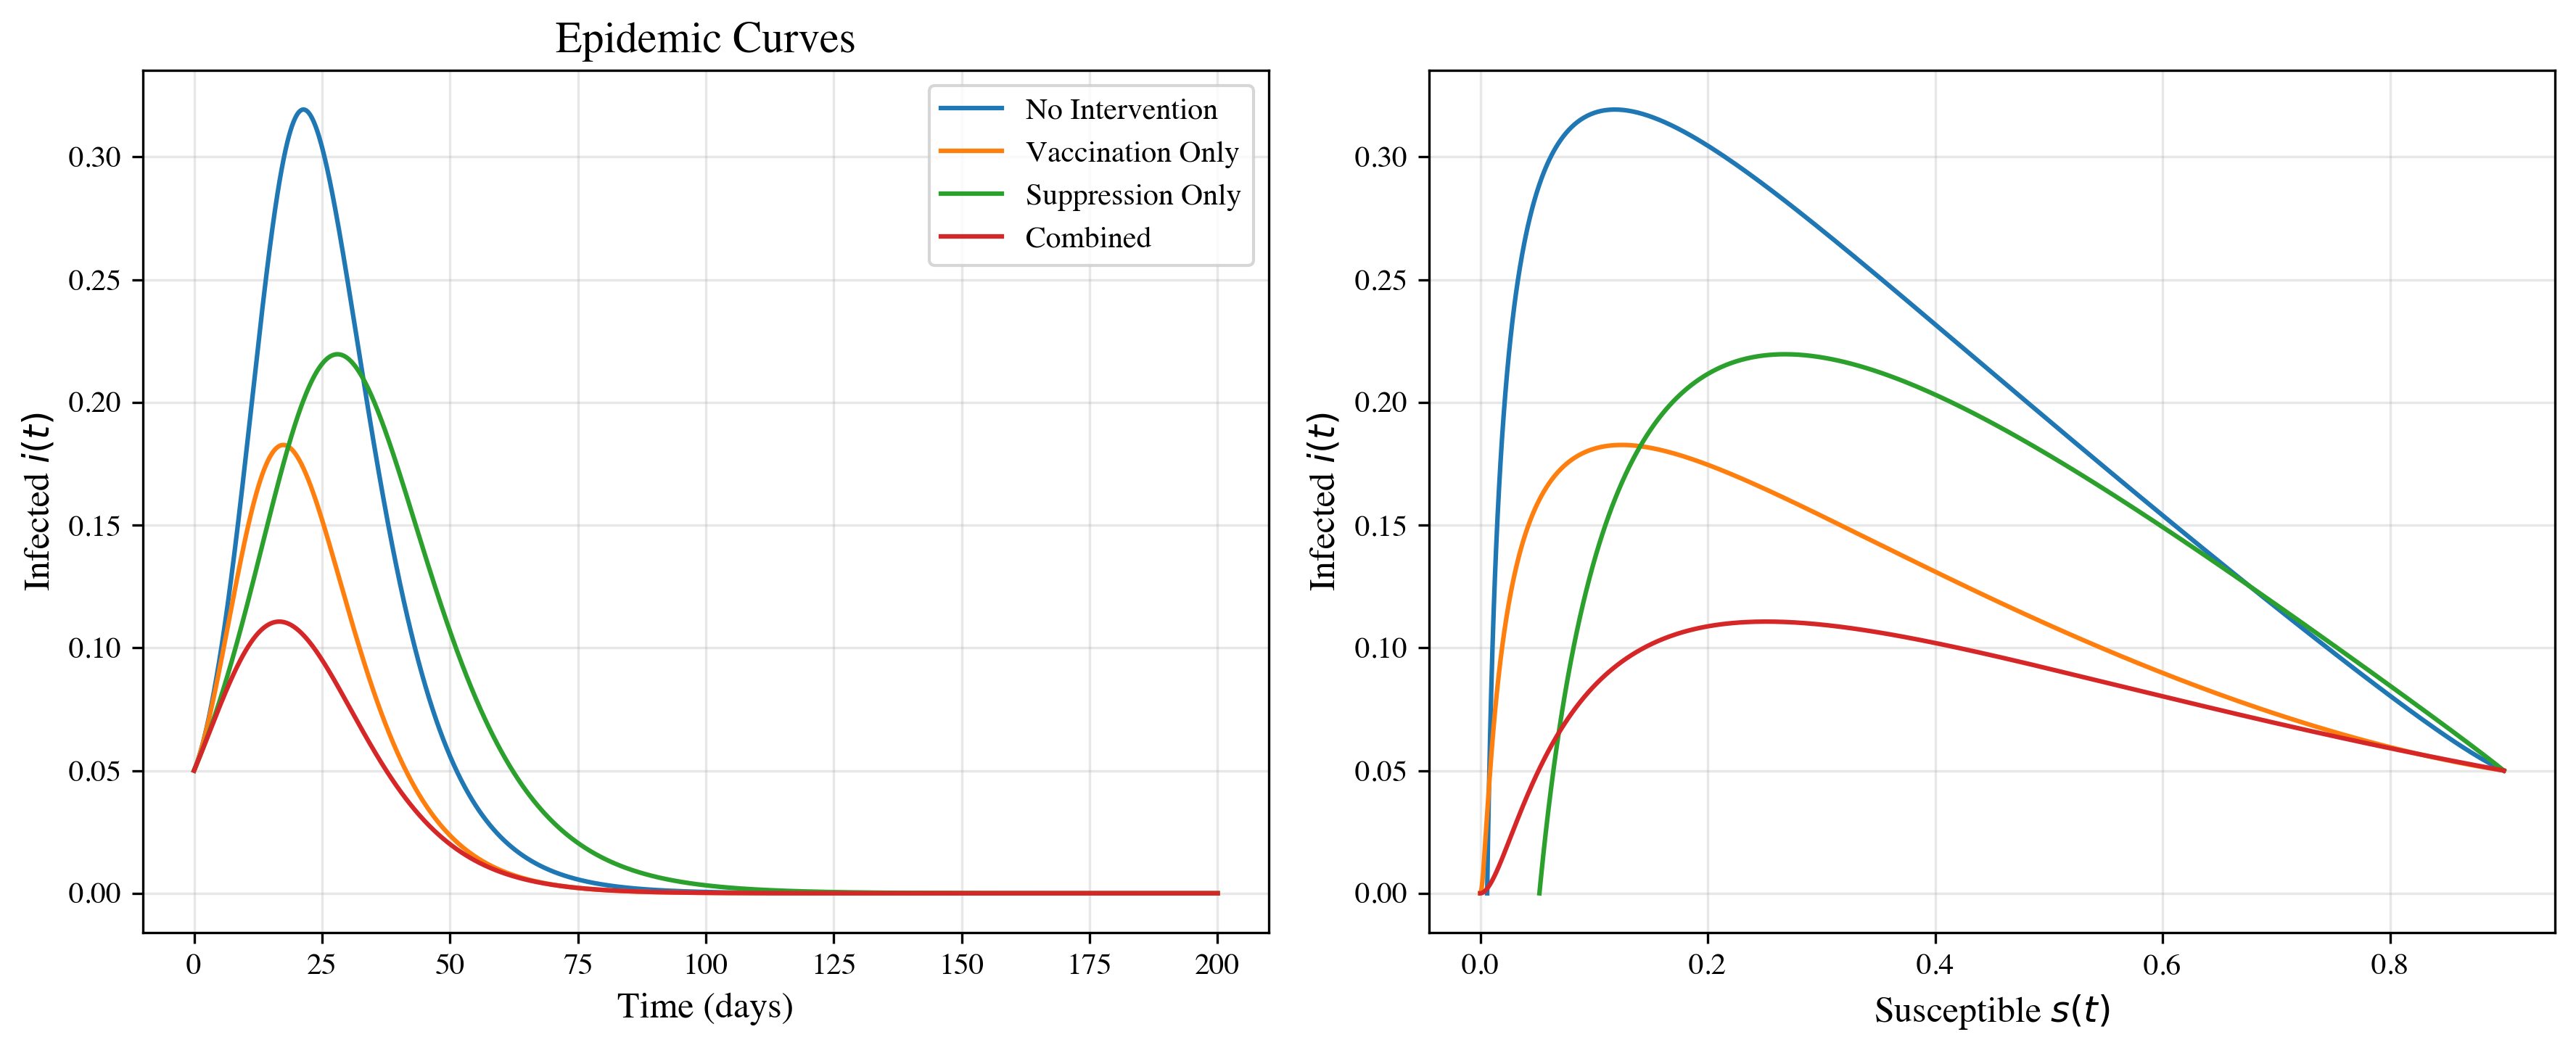

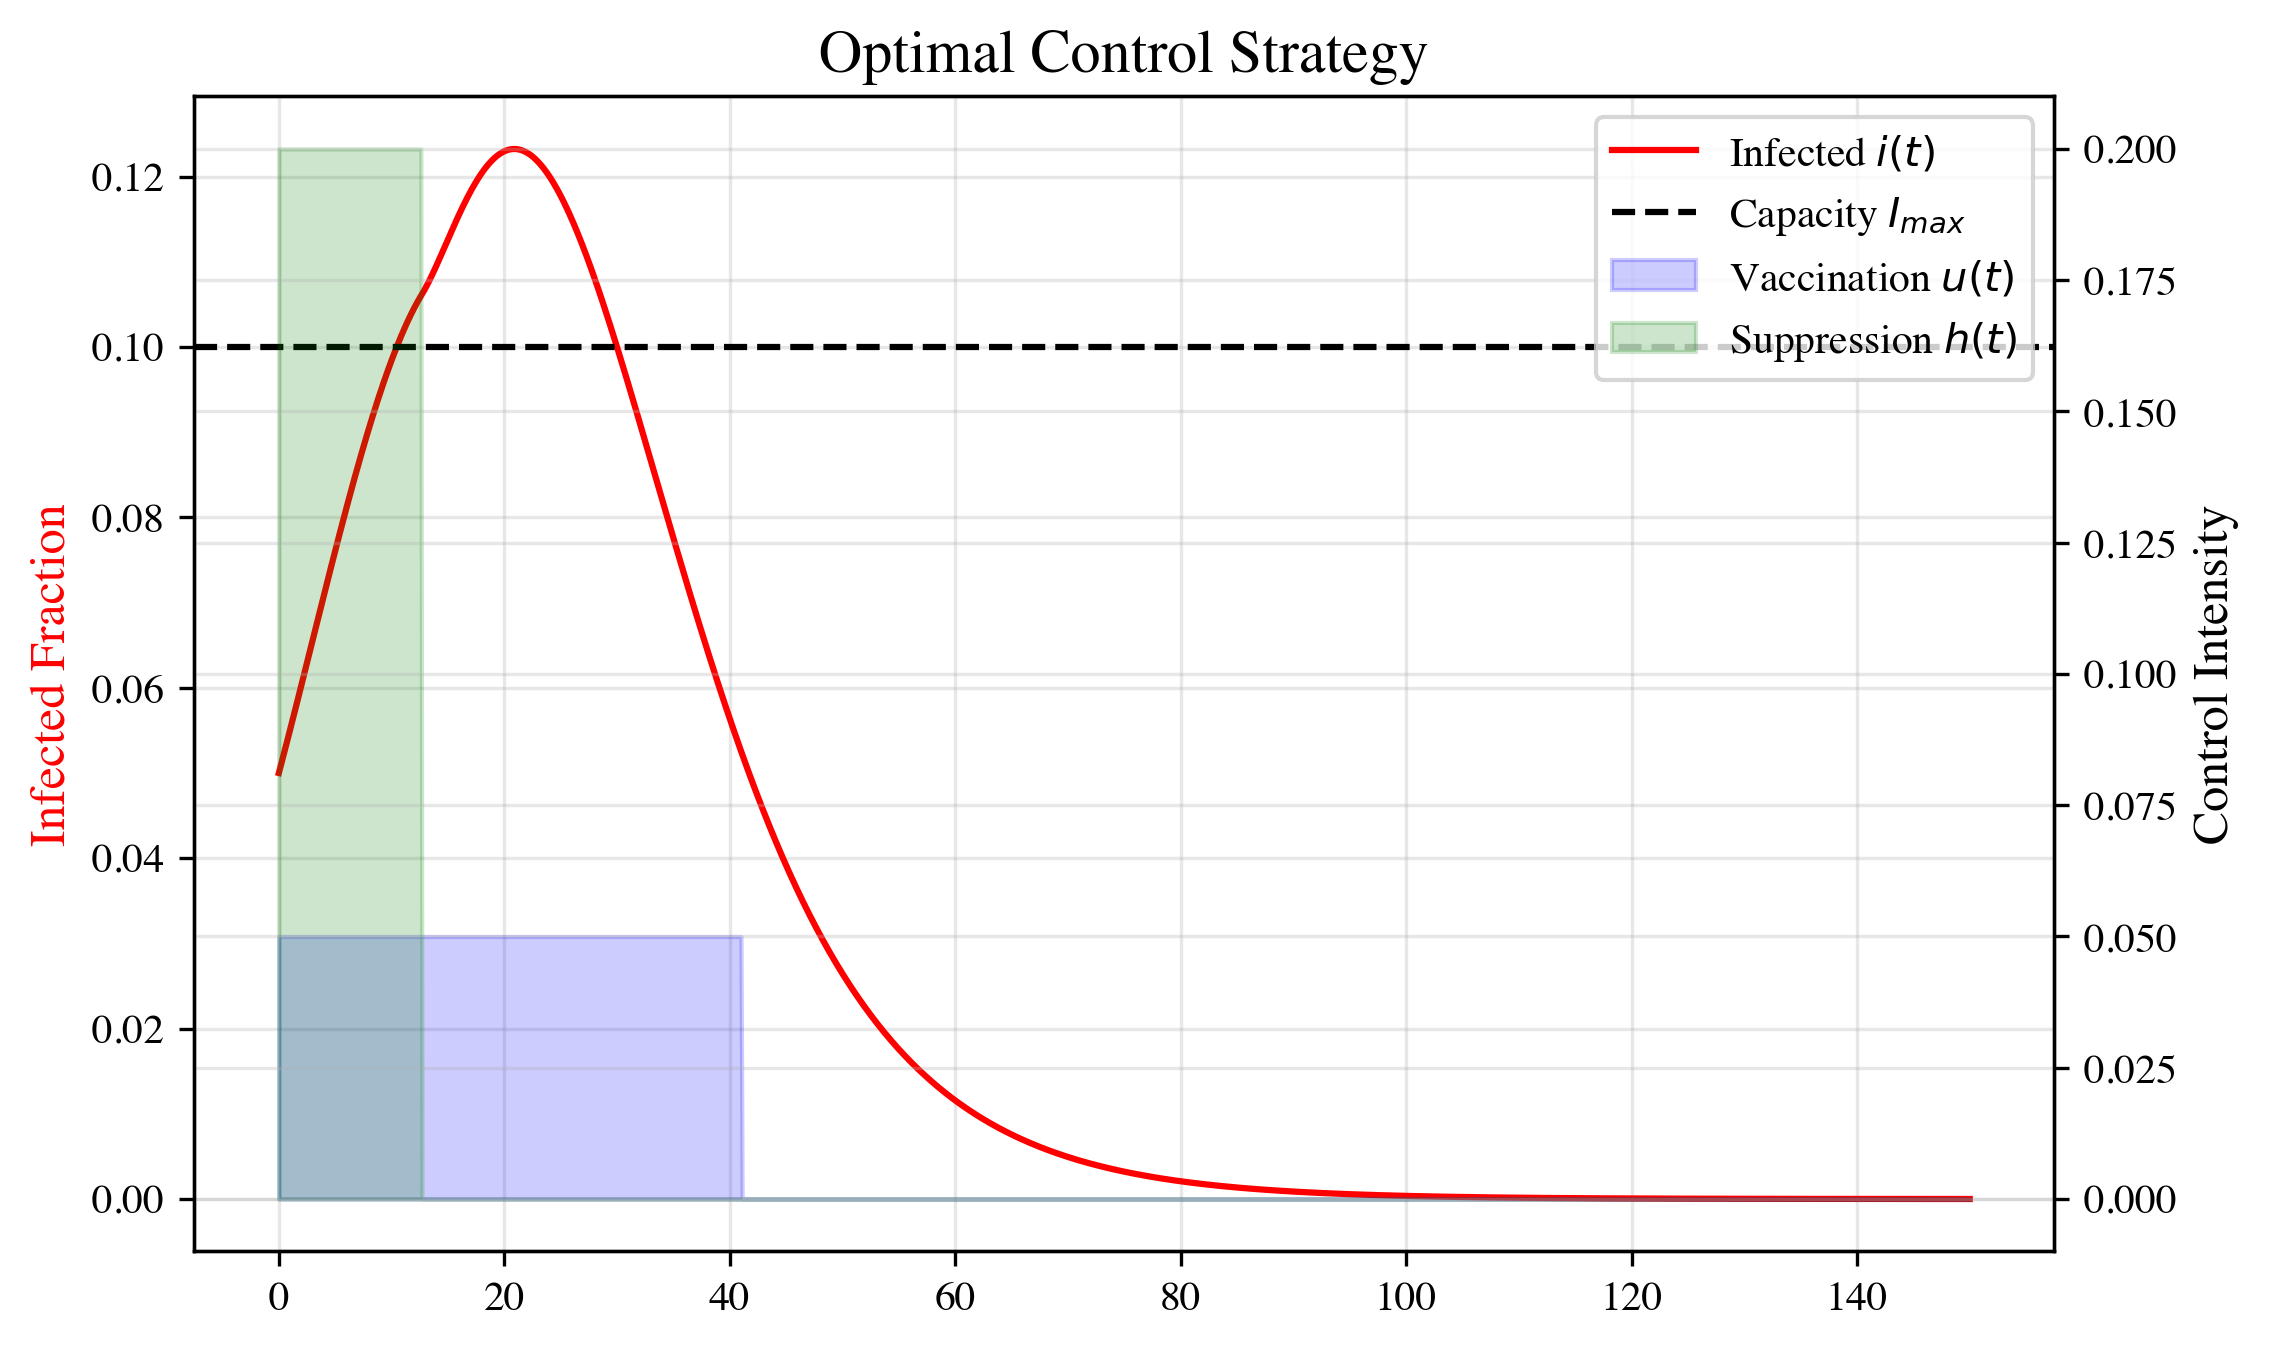

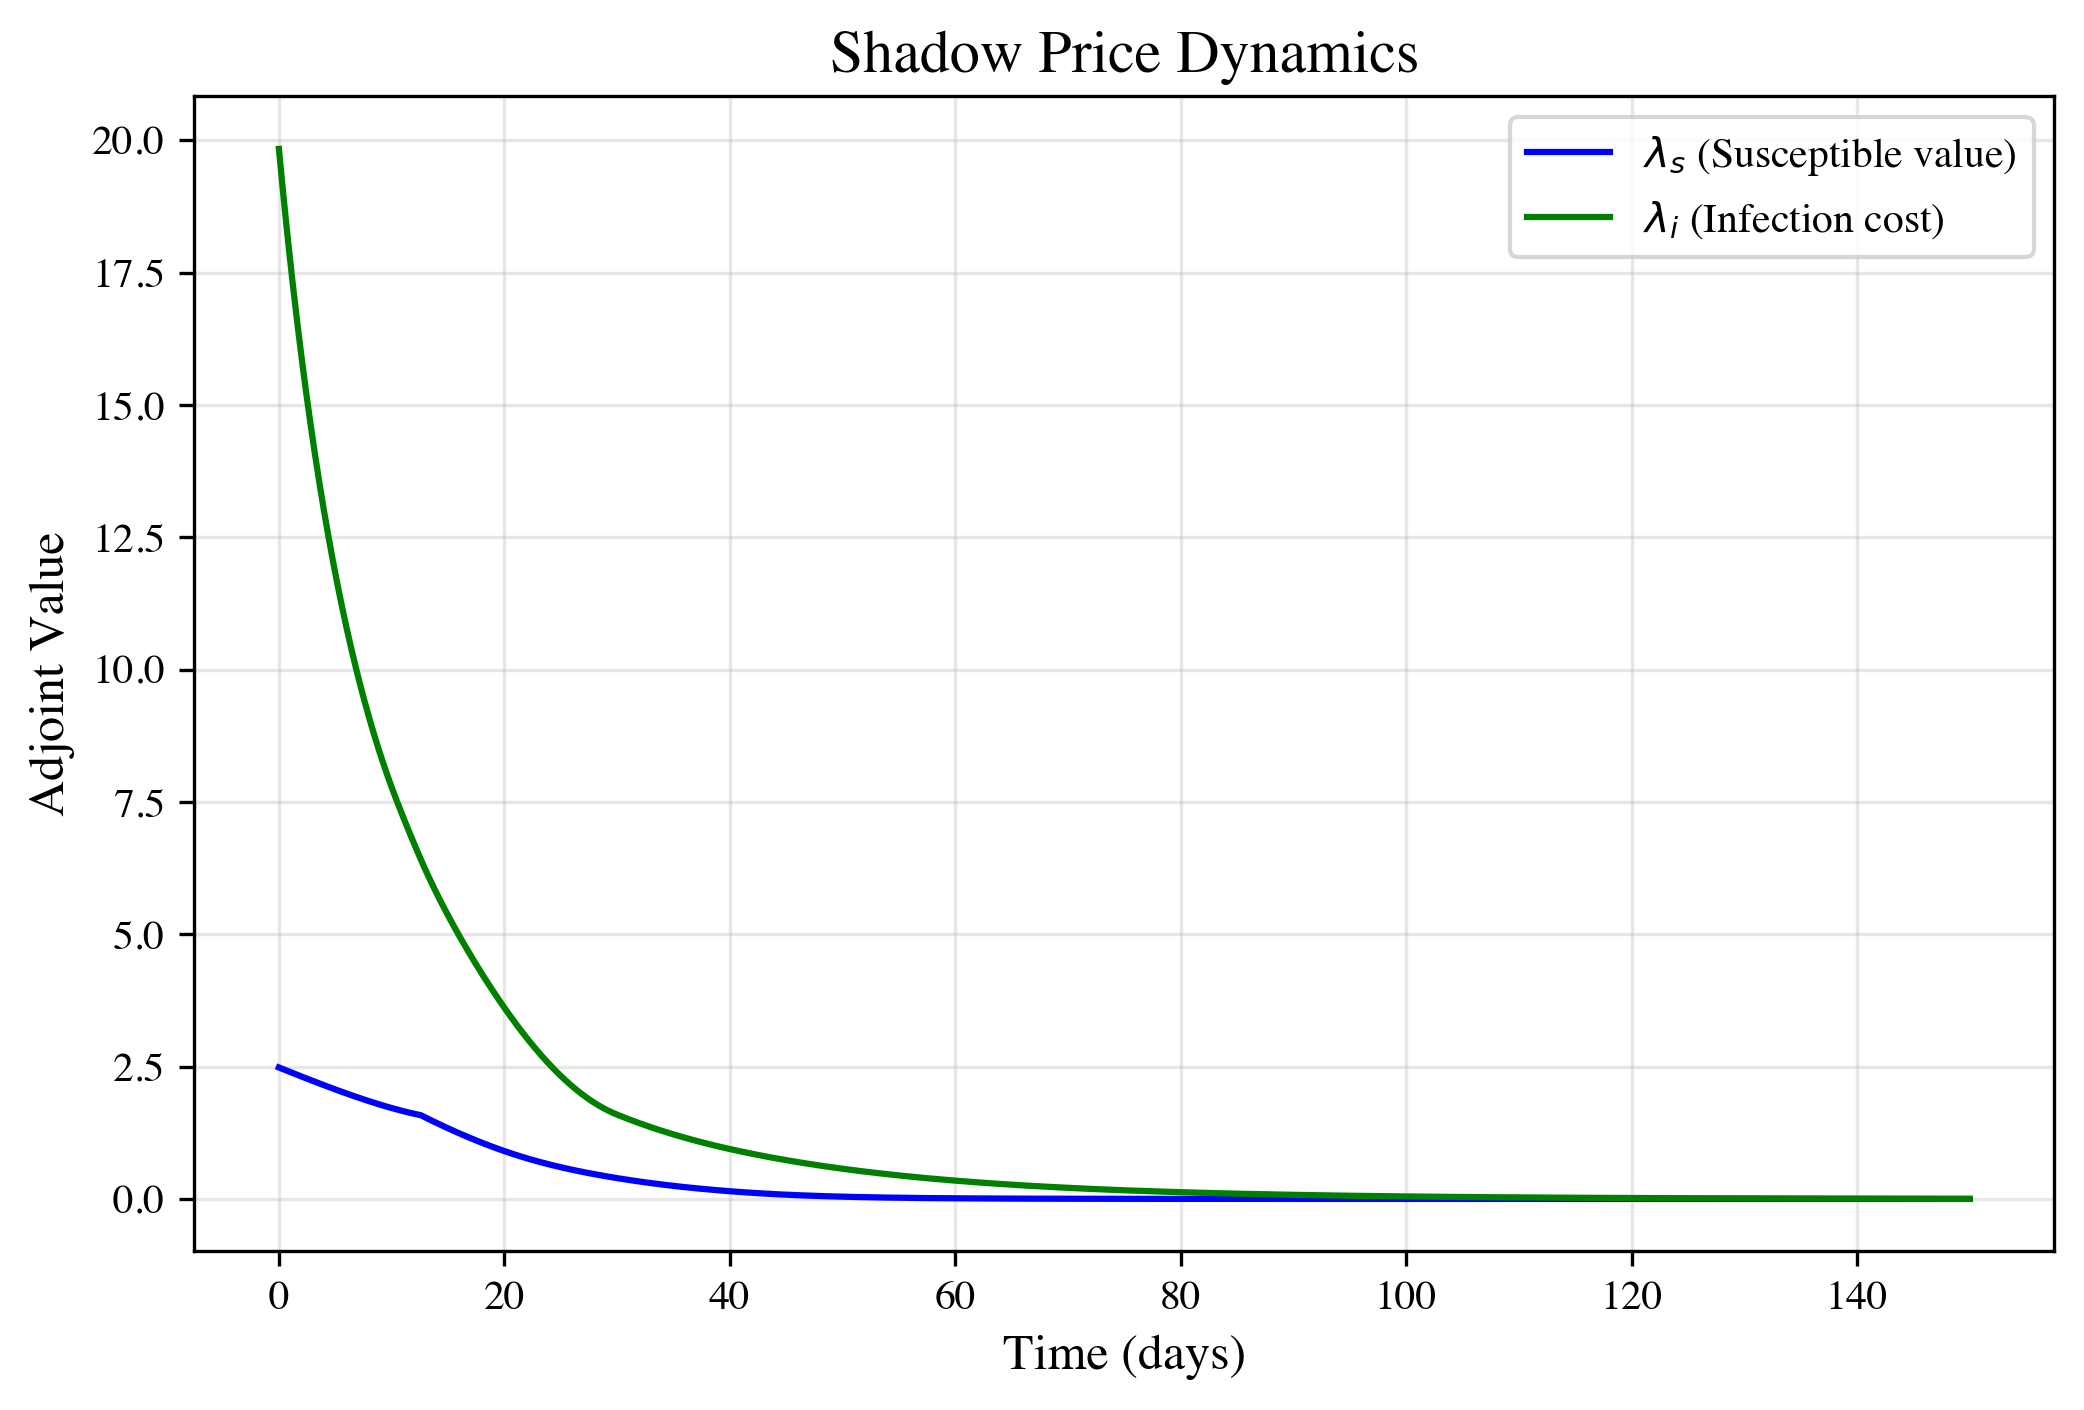

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc

# --- Professional Plotting Configuration ---
plt.rcParams.update({
    "text.usetex": False, # Set to True if you have LaTeX installed on your system
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman", "Times"],
    "axes.labelsize": 12,
    "font.size": 12,
    "legend.fontsize": 10,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "figure.figsize": [8, 5],
    "lines.linewidth": 1.5,
    "axes.grid": True,
    "grid.alpha": 0.3
})

class Params:
    def __init__(self, beta=0.5, sigma=0.2, gamma=0.1, I_max=0.1, 
                 u_max=0.05, h_max=0.2, t_delay_u=0.0, t_delay_h=0.0,
                 c_H=2.0, c_NH=1.0, c_V=1.0, delta=0.05, kappa=10.0):
        self.beta, self.sigma, self.gamma = beta, sigma, gamma
        self.I_max, self.u_max, self.h_max = I_max, u_max, h_max
        self.t_delay_u, self.t_delay_h = t_delay_u, t_delay_h
        self.c_H, self.c_NH, self.c_V = c_H, c_NH, c_V
        self.delta, self.kappa = delta, kappa

def f_state(x, u, h, p):
    s, e, i = x
    beta_eff = p.beta - h
    ds = -beta_eff * s * i - u * s
    de = beta_eff * s * i - p.sigma * e
    di = p.sigma * e - p.gamma * i
    return np.array([ds, de, di])

def adjoint_rhs(t, x, lam, u, h, p):
    s, e, i = x
    ls, le, li = lam
    be = p.beta - h
    disc = np.exp(-p.delta * t)
    dls = -p.c_V * u * disc + ls * (be * i + u) - le * be * i
    dle = p.sigma * (le - li)
    pen = 2.0 * p.kappa * np.maximum(0, i - p.I_max)
    dli = -(p.c_H * h + p.c_NH + pen) * disc + (ls - le) * be * s + p.gamma * li
    return np.array([dls, dle, dli])

def solve_fbs(x0, p, T=150, dt=0.1, max_iter=300):
    n = int(T/dt) + 1
    t = np.linspace(0, T, n)
    u, h = np.zeros(n), np.zeros(n)
    x, lam = np.zeros((n, 3)), np.zeros((n, 3))
    
    for it in range(max_iter):
        # Forward State
        x[0] = x0
        for k in range(n-1):
            uk = 0 if t[k] < p.t_delay_u else u[k]
            hk = 0 if t[k] < p.t_delay_h else h[k]
            k1 = f_state(x[k], uk, hk, p)
            k2 = f_state(x[k]+0.5*dt*k1, uk, hk, p)
            x[k+1] = x[k] + dt*k2
        
        # Backward Adjoint
        lam[-1] = [0, 0, 0]
        for k in range(n-1, 0, -1):
            k1 = adjoint_rhs(t[k], x[k], lam[k], u[k], h[k], p)
            lam[k-1] = lam[k] - dt*k1

        # Control Update
        disc = np.exp(-p.delta * t)
        phi_u = x[:, 0] * (p.c_V * disc - lam[:, 0])
        phi_h = x[:, 2] * (p.c_H * disc + x[:, 0] * (lam[:, 0] - lam[:, 1]))
        
        u_new = np.clip(np.where(phi_u < 0, p.u_max, 0), 0, p.u_max)
        h_new = np.clip(np.where(phi_h < 0, p.h_max, 0), 0, p.h_max)
        
        # Heavy relaxation for convergence stability
        u = 0.9 * u + 0.1 * u_new
        h = 0.9 * h + 0.1 * h_new
        
        if it > 50 and np.max(np.abs(u_new - u)) < 1e-5: break

    J = np.trapz([(p.c_H*x[k,2]*h[k] + p.c_NH*x[k,2] + p.c_V*u[k]*x[k,0] + 
                   p.kappa*max(0, x[k,2]-p.I_max)**2)*np.exp(-p.delta*t[k]) for k in range(n)], t)
    return t, x, u, h, lam, J

def run_simulations():
    x0 = [0.9, 0.05, 0.05]
    p = Params()
    
    # --- 1. Comparative Heuristics ---
    t_h = np.linspace(0, 200, 2001)
    dt = 0.1
    strategies = {
        'No Intervention': (0, 0),
        'Vaccination Only': (p.u_max, 0),
        'Suppression Only': (0, p.h_max),
        'Combined': (p.u_max, p.h_max)
    }
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    for name, (uv, hv) in strategies.items():
        x = np.zeros((2001, 3))
        x[0] = x0
        for k in range(2000):
            x[k+1] = x[k] + dt * f_state(x[k], uv, hv, p)
        ax1.plot(t_h, x[:, 2], label=name)
        ax2.plot(x[:, 0], x[:, 2], label=name)
        peak = np.max(x[:, 2])
        size = 1 - x[-1, 0]
        print(f"Strategy: {name:18} | Peak: {peak:.4f} | Size: {size:.4f}")

    ax1.set_xlabel('Time (days)'); ax1.set_ylabel('Infected $i(t)$')
    ax2.set_xlabel('Susceptible $s(t)$'); ax2.set_ylabel('Infected $i(t)$')
    ax1.legend(); ax1.set_title("Epidemic Curves")
    plt.tight_layout()
    plt.savefig("fig_interventions.png", dpi=300)

    # --- 2. Optimal Control & Shadow Prices ---
    t, x, u, h, lam, J = solve_fbs(x0, p)
    
    # Optimal State/Control Plot
    fig, ax1 = plt.subplots()
    ax1.plot(t, x[:, 2], 'r-', label='Infected $i(t)$')
    ax1.axhline(p.I_max, color='k', linestyle='--', label='Capacity $I_{max}$')
    ax1.set_ylabel('Infected Fraction', color='r')
    ax2 = ax1.twinx()
    ax2.fill_between(t, u, color='b', alpha=0.2, label='Vaccination $u(t)$')
    ax2.fill_between(t, h, color='g', alpha=0.2, label='Suppression $h(t)$')
    ax2.set_ylabel('Control Intensity')
    plt.title("Optimal Control Strategy")
    fig.legend(loc="upper right", bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)
    plt.savefig("fig_optimal.png", dpi=300)

    # Shadow Prices Plot
    plt.figure()
    plt.plot(t, lam[:, 0], 'b-', label=r'$\lambda_s$ (Susceptible value)')
    plt.plot(t, lam[:, 2], 'g-', label=r'$\lambda_i$ (Infection cost)')
    plt.xlabel('Time (days)'); plt.ylabel('Adjoint Value')
    plt.title("Shadow Price Dynamics")
    plt.legend(); plt.savefig("fig_shadow_prices.png", dpi=300)

if __name__ == "__main__":
    run_simulations()

In [10]:
#!/usr/bin/env python3
"""
Publication-ready SEIR controlled simulations + penalized optimal control (finite horizon)

Outputs (default: ./outputs):
  figures/
    fig_interventions.pdf            (i(t) + phase plane)
    fig_time_varying.pdf             (i(t), u(t), h(t) for schedules)
    fig_optimal_controls.pdf         (u(t), h(t), i(t) with I_max)
    fig_shadow_prices.pdf            (lambda_s, lambda_e, lambda_i)
    fig_corr_heatmap.pdf             (correlation heatmap)
    fig_boxplots_capacity.pdf        (boxplots for beta/u_max/h_max median splits)
    fig_boxplots_delays.pdf          (boxplots for delays median splits)
  tables/
    tab_heuristic_interventions.tex
    tab_time_varying_schedules.tex
    heuristic_interventions.csv
    time_varying_schedules.csv
    sensitivity_samples.csv
  data/
    optimal_solution.npz
  meta/
    run_summary.txt
    optimal_summary.txt

Dependencies: numpy, matplotlib
Run (CLI):
  python seir_numerics.py --outdir outputs --n_sens 24 --seed 42

Run (Jupyter):
  import seir_numerics as sn
  sn.main([])  # no argv parsing issues
"""

from __future__ import annotations

import argparse
import csv
import logging
from dataclasses import dataclass, asdict
from pathlib import Path
from typing import Callable, Dict, List, Optional, Tuple

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt


# =============================================================================
# Logging + matplotlib defaults (publication-friendly)
# =============================================================================
logger = logging.getLogger("seir_numerics")
logging.basicConfig(level=logging.INFO, format="%(levelname)s: %(message)s")

mpl.rcParams.update(
    {
        "figure.dpi": 150,
        "savefig.dpi": 300,
        "font.size": 11,
        "axes.titlesize": 12,
        "axes.labelsize": 11,
        "legend.fontsize": 10,
        "lines.linewidth": 2.0,
        "axes.grid": True,
        "grid.alpha": 0.25,
        "grid.linestyle": "-",
        "figure.constrained_layout.use": True,
    }
)


# =============================================================================
# Utilities
# =============================================================================
def pospart(x: np.ndarray | float) -> np.ndarray | float:
    return np.maximum(0.0, x)


def logistic(z: np.ndarray | float) -> np.ndarray | float:
    z = np.clip(z, -60.0, 60.0)
    return 1.0 / (1.0 + np.exp(-z))


def ensure_simplex_sei(x: np.ndarray) -> np.ndarray:
    """
    Project (s,e,i) to nonnegative and s+e+i <= 1 (numerical stabilization only).
    """
    x = np.maximum(x, 0.0)
    tot = float(np.sum(x))
    if tot > 1.0:
        x = x / tot
    return x


def trapz(y: np.ndarray, t: np.ndarray) -> float:
    return float(np.trapz(y, t))


def write_csv(path: Path, header: List[str], rows: List[List[float | str]]) -> None:
    path.parent.mkdir(parents=True, exist_ok=True)
    with path.open("w", newline="", encoding="utf-8") as f:
        w = csv.writer(f)
        w.writerow(header)
        w.writerows(rows)


def latex_escape(s: str) -> str:
    # minimal escaping for scenario names
    return (
        s.replace("&", "\\&")
        .replace("%", "\\%")
        .replace("_", "\\_")
        .replace("#", "\\#")
        .replace("$", "\\$")
    )


def write_latex_table_peak_final(
    path: Path,
    rows: List[Tuple[str, float, float]],
    caption: str,
    label: str,
) -> None:
    """
    Writes a LaTeX table with columns: Scenario, Peak i(t), Final size (1-s(T)).
    """
    path.parent.mkdir(parents=True, exist_ok=True)
    lines = []
    lines.append("\\begin{table}[ht]\n")
    lines.append("\\centering\n")
    lines.append(f"\\caption{{{caption}}}\n")
    lines.append(f"\\label{{{label}}}\n")
    lines.append("\\begin{tabular}{lcc}\n")
    lines.append("\\toprule\n")
    lines.append("\\textbf{Scenario} & \\textbf{Peak $i(t)$} & \\textbf{Final Size $1-s(T)$} \\\\\n")
    lines.append("\\midrule\n")
    for name, peak_i, final_size in rows:
        lines.append(f"{latex_escape(name)} & {peak_i:.4f} & {final_size:.4f} \\\\\n")
    lines.append("\\bottomrule\n")
    lines.append("\\end{tabular}\n")
    lines.append("\\end{table}\n")
    path.write_text("".join(lines), encoding="utf-8")


# =============================================================================
# Model + cost
# =============================================================================
@dataclass(frozen=True)
class Params:
    beta: float = 0.5
    sigma: float = 0.2
    gamma: float = 0.1

    I_max: float = 0.1
    u_max: float = 0.05
    h_max: float = 0.2

    t_delay_u: float = 0.0
    t_delay_h: float = 0.0

    c_H: float = 2.0
    c_NH: float = 1.0
    c_V: float = 1.0

    delta: float = 0.05
    kappa: float = 10.0


@dataclass(frozen=True)
class FBSSettings:
    T: float = 150.0
    dt: float = 0.1
    max_iter: int = 300
    tol: float = 2e-6
    relax: float = 0.25
    smooth_eps: float = 3e-3
    verbose: bool = True


def f_state(x: np.ndarray, u: float, h: float, p: Params) -> np.ndarray:
    """
    Reduced SEI dynamics:
      s' = -(beta-h) s i - u s
      e' = (beta-h) s i - sigma e
      i' = sigma e - gamma i
    """
    s, e, i = x
    beta_eff = p.beta - h
    ds = -(beta_eff) * s * i - u * s
    de = (beta_eff) * s * i - p.sigma * e
    di = p.sigma * e - p.gamma * i
    return np.array([ds, de, di], dtype=float)


def running_cost(t: float, x: np.ndarray, u: float, h: float, p: Params) -> float:
    """
    l_kappa(t) = (c_H i h + c_NH i + c_V u s + kappa*(max(0,i-Imax))^2) * exp(-delta t)
    """
    s, _, i = x
    L0 = p.c_H * i * h + p.c_NH * i + p.c_V * u * s
    penalty = p.kappa * float(pospart(i - p.I_max) ** 2)
    return float((L0 + penalty) * np.exp(-p.delta * t))


def adjoint_rhs(t: float, x: np.ndarray, lam: np.ndarray, u: float, h: float, p: Params) -> np.ndarray:
    """
    Costate equations for finite horizon with terminal condition lam(T)=0:
      lam_s' = -c_V u e^{-δt} + lam_s((β-h)i+u) - lam_e(β-h)i
      lam_e' = σ(lam_e - lam_i)
      lam_i' = -[c_H h + c_NH + 2κ(i-Imax)_+] e^{-δt} + (lam_s-lam_e)(β-h)s + γ lam_i
    """
    s, _, i = x
    lam_s, lam_e, lam_i = lam
    beta_eff = p.beta - h
    disc = float(np.exp(-p.delta * t))

    dlam_s = -p.c_V * u * disc + lam_s * (beta_eff * i + u) - lam_e * (beta_eff * i)
    dlam_e = p.sigma * (lam_e - lam_i)
    dlam_i = (
        -(p.c_H * h + p.c_NH + 2.0 * p.kappa * float(pospart(i - p.I_max))) * disc
        + (lam_s - lam_e) * beta_eff * s
        + p.gamma * lam_i
    )
    return np.array([dlam_s, dlam_e, dlam_i], dtype=float)


# =============================================================================
# RK4 integrators (from scratch)
# =============================================================================
def rk4_forward_step(x: np.ndarray, t: float, dt: float, u: float, h: float, p: Params) -> np.ndarray:
    k1 = f_state(x, u, h, p)
    k2 = f_state(x + 0.5 * dt * k1, u, h, p)
    k3 = f_state(x + 0.5 * dt * k2, u, h, p)
    k4 = f_state(x + dt * k3, u, h, p)
    xn = x + (dt / 6.0) * (k1 + 2 * k2 + 2 * k3 + k4)
    return ensure_simplex_sei(xn)


def rk4_backward_step(lam_t: np.ndarray, t: float, dt: float, x_t: np.ndarray, u_t: float, h_t: float, p: Params) -> np.ndarray:
    """
    Backward integration: compute lam(t-dt) given lam(t) using RK4.
    """
    k1 = adjoint_rhs(t, x_t, lam_t, u_t, h_t, p)
    k2 = adjoint_rhs(t - 0.5 * dt, x_t, lam_t - 0.5 * dt * k1, u_t, h_t, p)
    k3 = adjoint_rhs(t - 0.5 * dt, x_t, lam_t - 0.5 * dt * k2, u_t, h_t, p)
    k4 = adjoint_rhs(t - dt, x_t, lam_t - dt * k3, u_t, h_t, p)
    lam_prev = lam_t - (dt / 6.0) * (k1 + 2 * k2 + 2 * k3 + k4)
    return lam_prev


# =============================================================================
# Simulation primitives
# =============================================================================
def enforce_bounds_and_delays(t: float, u: float, h: float, p: Params) -> Tuple[float, float]:
    if t < p.t_delay_u:
        u = 0.0
    if t < p.t_delay_h:
        h = 0.0
    u = float(np.clip(u, 0.0, p.u_max))
    h = float(np.clip(h, 0.0, p.h_max))
    return u, h


def simulate_with_control_function(
    x0: Tuple[float, float, float],
    p: Params,
    T: float,
    dt: float,
    control_fn: Callable[[float, np.ndarray], Tuple[float, float]],
) -> Dict[str, np.ndarray]:
    n = int(np.floor(T / dt)) + 1
    t = np.linspace(0.0, T, n)
    x = np.zeros((n, 3), dtype=float)
    u = np.zeros(n, dtype=float)
    h = np.zeros(n, dtype=float)

    x[0] = ensure_simplex_sei(np.array(x0, dtype=float))

    for k in range(n - 1):
        tk = float(t[k])
        uk, hk = control_fn(tk, x[k])
        uk, hk = enforce_bounds_and_delays(tk, uk, hk, p)
        u[k], h[k] = uk, hk
        x[k + 1] = rk4_forward_step(x[k], tk, dt, uk, hk, p)

    u[-1], h[-1] = u[-2], h[-2]
    r = 1.0 - np.sum(x, axis=1)
    r = np.maximum(r, 0.0)

    return {"t": t, "x": x, "r": r, "u": u, "h": h}


def summarize_peak_final(sim: Dict[str, np.ndarray]) -> Tuple[float, float]:
    x = sim["x"]
    peak_i = float(np.max(x[:, 2]))
    final_size = float(1.0 - x[-1, 0])  # 1 - s(T)
    return peak_i, final_size


def objective_from_trajectory(sim: Dict[str, np.ndarray], p: Params) -> float:
    t, x, u, h = sim["t"], sim["x"], sim["u"], sim["h"]
    vals = np.array([running_cost(float(tk), xk, float(uk), float(hk), p) for tk, xk, uk, hk in zip(t, x, u, h)], dtype=float)
    return trapz(vals, t)


# =============================================================================
# Penalized PMP optimal control (forward-backward sweep)
# =============================================================================
def solve_optimal_control_fbs(
    x0: Tuple[float, float, float],
    p: Params,
    settings: FBSSettings,
) -> Dict[str, np.ndarray]:
    T, dt = float(settings.T), float(settings.dt)
    n = int(np.floor(T / dt)) + 1
    t = np.linspace(0.0, T, n)

    # controls
    u = np.zeros(n, dtype=float)
    h = np.zeros(n, dtype=float)

    # state + adjoint
    x = np.zeros((n, 3), dtype=float)
    lam = np.zeros((n, 3), dtype=float)

    J_hist: List[float] = []

    def compute_J() -> float:
        vals = np.array([running_cost(float(t[k]), x[k], float(u[k]), float(h[k]), p) for k in range(n)], dtype=float)
        return trapz(vals, t)

    J_prev = np.inf

    for it in range(1, settings.max_iter + 1):
        # ---- forward state
        x[0] = ensure_simplex_sei(np.array(x0, dtype=float))
        for k in range(n - 1):
            tk = float(t[k])
            uk, hk = enforce_bounds_and_delays(tk, float(u[k]), float(h[k]), p)
            x[k + 1] = rk4_forward_step(x[k], tk, dt, uk, hk, p)

        # ---- backward adjoint (terminal condition)
        lam[-1] = np.zeros(3, dtype=float)
        for k in range(n - 1, 0, -1):
            tk = float(t[k])
            uk, hk = enforce_bounds_and_delays(tk, float(u[k]), float(h[k]), p)
            lam[k - 1] = rk4_backward_step(lam[k], tk, dt, x[k], uk, hk, p)

        # ---- switching functions
        disc = np.exp(-p.delta * t)
        Phi_u = x[:, 0] * (p.c_V * disc - lam[:, 0])
        Phi_h = x[:, 2] * (p.c_H * disc + x[:, 0] * (lam[:, 0] - lam[:, 1]))

        # smoothed bang-bang minimizer
        u_bar = p.u_max * logistic((-Phi_u) / settings.smooth_eps)
        h_bar = p.h_max * logistic((-Phi_h) / settings.smooth_eps)

        # enforce delays exactly
        u_bar = np.where(t < p.t_delay_u, 0.0, u_bar)
        h_bar = np.where(t < p.t_delay_h, 0.0, h_bar)

        # relaxation
        u_new = (1.0 - settings.relax) * u + settings.relax * u_bar
        h_new = (1.0 - settings.relax) * h + settings.relax * h_bar

        # bounds
        u_new = np.clip(u_new, 0.0, p.u_max)
        h_new = np.clip(h_new, 0.0, p.h_max)

        du = float(np.max(np.abs(u_new - u)))
        dh = float(np.max(np.abs(h_new - h)))
        u, h = u_new, h_new

        J = compute_J()
        J_hist.append(J)
        dJ = abs(J_prev - J) if np.isfinite(J_prev) else np.inf
        J_prev = J

        if settings.verbose and (it == 1 or it % 10 == 0):
            logger.info(f"[FBS] iter={it:3d}  J={J: .8f}  |du|_inf={du:.3e}  |dh|_inf={dh:.3e}  |dJ|={dJ:.3e}")

        if max(du, dh) < settings.tol and dJ < 1e-8:
            if settings.verbose:
                logger.info(f"[FBS] converged at iter={it}  J={J:.8f}")
            break

    r = 1.0 - np.sum(x, axis=1)
    r = np.maximum(r, 0.0)

    return {"t": t, "x": x, "r": r, "u": u, "h": h, "lam": lam, "J": np.array(J_prev), "J_hist": np.array(J_hist)}


# =============================================================================
# Figures (PDF + PNG)
# =============================================================================
def savefig_dual(fig: plt.Figure, outdir: Path, stem: str) -> None:
    outdir.mkdir(parents=True, exist_ok=True)
    fig.savefig(outdir / f"{stem}.pdf")
    fig.savefig(outdir / f"{stem}.png")
    plt.close(fig)


def fig_interventions(outdir: Path, sims: Dict[str, Dict[str, np.ndarray]], I_max: float) -> None:
    # Two panels: i(t), phase plane s vs i
    fig, axes = plt.subplots(1, 2, figsize=(10.5, 4.0))

    ax = axes[0]
    for name, sim in sims.items():
        ax.plot(sim["t"], sim["x"][:, 2], label=name)
    ax.axhline(I_max, linestyle="--", label=r"$I_{\max}$")
    ax.set_xlabel("Time (days)")
    ax.set_ylabel(r"Infected fraction $i(t)$")
    ax.set_title("Heuristic interventions: infection path")
    ax.legend(frameon=True)

    ax = axes[1]
    for name, sim in sims.items():
        ax.plot(sim["x"][:, 0], sim["x"][:, 2], label=name)
    ax.set_xlabel(r"Susceptible fraction $s(t)$")
    ax.set_ylabel(r"Infected fraction $i(t)$")
    ax.set_title("Phase plane: $s(t)$ vs $i(t)$")
    ax.legend(frameon=True)

    savefig_dual(fig, outdir / "figures", "fig_interventions")


def fig_time_varying(outdir: Path, sims: Dict[str, Dict[str, np.ndarray]], I_max: float) -> None:
    # Three panels: i(t), u(t), h(t)
    fig, axes = plt.subplots(3, 1, figsize=(9.0, 9.0), sharex=True)

    ax = axes[0]
    for name, sim in sims.items():
        ax.plot(sim["t"], sim["x"][:, 2], label=name)
    ax.axhline(I_max, linestyle="--", label=r"$I_{\max}$")
    ax.set_ylabel(r"$i(t)$")
    ax.set_title("Time-varying schedules: infection paths")
    ax.legend(frameon=True)

    ax = axes[1]
    for name, sim in sims.items():
        ax.plot(sim["t"], sim["u"], label=name)
    ax.set_ylabel(r"$u(t)$")
    ax.set_title("Vaccination schedules")
    ax.legend(frameon=True)

    ax = axes[2]
    for name, sim in sims.items():
        ax.plot(sim["t"], sim["h"], label=name)
    ax.set_xlabel("Time (days)")
    ax.set_ylabel(r"$h(t)$")
    ax.set_title("Suppression schedules")
    ax.legend(frameon=True)

    savefig_dual(fig, outdir / "figures", "fig_time_varying")


def fig_optimal_controls(outdir: Path, sol: Dict[str, np.ndarray], I_max: float) -> None:
    fig, axes = plt.subplots(3, 1, figsize=(9.0, 9.0), sharex=True)

    t = sol["t"]
    x = sol["x"]
    u = sol["u"]
    h = sol["h"]

    axes[0].plot(t, x[:, 2], label=r"$i(t)$")
    axes[0].axhline(I_max, linestyle="--", label=r"$I_{\max}$")
    axes[0].set_ylabel(r"$i(t)$")
    axes[0].set_title("Optimal (penalized) control: infection")
    axes[0].legend(frameon=True)

    axes[1].plot(t, u, label=r"$u(t)$")
    axes[1].set_ylabel(r"$u(t)$")
    axes[1].set_title("Optimal vaccination")
    axes[1].legend(frameon=True)

    axes[2].plot(t, h, label=r"$h(t)$")
    axes[2].set_xlabel("Time (days)")
    axes[2].set_ylabel(r"$h(t)$")
    axes[2].set_title("Optimal suppression")
    axes[2].legend(frameon=True)

    savefig_dual(fig, outdir / "figures", "fig_optimal_controls")


def fig_shadow_prices(outdir: Path, sol: Dict[str, np.ndarray]) -> None:
    fig, ax = plt.subplots(1, 1, figsize=(9.0, 4.5))
    t = sol["t"]
    lam = sol["lam"]
    ax.plot(t, lam[:, 0], label=r"$\lambda_s$")
    ax.plot(t, lam[:, 1], label=r"$\lambda_e$")
    ax.plot(t, lam[:, 2], label=r"$\lambda_i$")
    ax.set_xlabel("Time (days)")
    ax.set_ylabel("Adjoint value")
    ax.set_title("Shadow prices under optimal control")
    ax.legend(frameon=True)
    savefig_dual(fig, outdir / "figures", "fig_shadow_prices")


def fig_corr_heatmap(outdir: Path, X: np.ndarray, names: List[str]) -> None:
    C = np.corrcoef(X.T)

    fig, ax = plt.subplots(1, 1, figsize=(7.5, 6.2))
    im = ax.imshow(C, aspect="auto")
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

    ax.set_xticks(range(len(names)))
    ax.set_yticks(range(len(names)))
    ax.set_xticklabels(names, rotation=45, ha="right")
    ax.set_yticklabels(names)
    ax.set_title("Correlation heatmap")

    # annotate values
    for i in range(C.shape[0]):
        for j in range(C.shape[1]):
            ax.text(j, i, f"{C[i, j]:.2f}", ha="center", va="center", fontsize=8)

    savefig_dual(fig, outdir / "figures", "fig_corr_heatmap")


def fig_boxplots(outdir: Path, groups: List[np.ndarray], labels: List[str], title: str, stem: str) -> None:
    fig, ax = plt.subplots(1, 1, figsize=(10.5, 4.6))
    ax.boxplot(groups, labels=labels, showfliers=False)
    ax.set_ylabel(r"Total cost $J_T$")
    ax.set_title(title)
    ax.tick_params(axis="x", rotation=25)
    savefig_dual(fig, outdir / "figures", stem)


# =============================================================================
# Sensitivity analysis
# =============================================================================
def sensitivity(
    x0: Tuple[float, float, float],
    base: Params,
    settings: FBSSettings,
    n_samples: int,
    seed: int,
    outdir: Path,
) -> Dict[str, np.ndarray]:
    rng = np.random.default_rng(seed)

    # Sample ranges (edit to match your design)
    betas = rng.uniform(0.35, 0.70, size=n_samples)
    umaxs = rng.uniform(0.01, 0.10, size=n_samples)
    hmaxs = rng.uniform(0.05, 0.30, size=n_samples)
    dU = rng.uniform(0.0, 20.0, size=n_samples)  # vaccination delay
    dH = rng.uniform(0.0, 20.0, size=n_samples)  # suppression delay
    cV = rng.uniform(0.5, 2.0, size=n_samples)
    cH = rng.uniform(0.5, 3.0, size=n_samples)

    J = np.zeros(n_samples, dtype=float)
    peak_i = np.zeros(n_samples, dtype=float)

    # For speed, you can reduce iterations slightly here
    sens_settings = FBSSettings(
        T=settings.T,
        dt=settings.dt,
        max_iter=min(settings.max_iter, 160),
        tol=settings.tol * 5,
        relax=settings.relax,
        smooth_eps=settings.smooth_eps,
        verbose=False,
    )

    for k in range(n_samples):
        p = Params(
            beta=float(betas[k]),
            sigma=base.sigma,
            gamma=base.gamma,
            I_max=base.I_max,
            u_max=float(umaxs[k]),
            h_max=float(hmaxs[k]),
            t_delay_u=float(dU[k]),
            t_delay_h=float(dH[k]),
            c_H=float(cH[k]),
            c_NH=base.c_NH,
            c_V=float(cV[k]),
            delta=base.delta,
            kappa=base.kappa,
        )

        sol = solve_optimal_control_fbs(x0, p, sens_settings)
        J[k] = float(sol["J"])
        peak_i[k] = float(np.max(sol["x"][:, 2]))

        if (k + 1) % max(1, n_samples // 5) == 0:
            logger.info(f"Sensitivity progress: {k+1}/{n_samples}")

    # Save raw samples
    rows = []
    for k in range(n_samples):
        rows.append([betas[k], umaxs[k], hmaxs[k], dU[k], dH[k], cV[k], cH[k], J[k], peak_i[k]])
    write_csv(
        outdir / "tables" / "sensitivity_samples.csv",
        ["beta", "u_max", "h_max", "t_delay_u", "t_delay_h", "c_V", "c_H", "J_T", "peak_i"],
        rows,
    )

    # Correlation heatmap
    X = np.column_stack([betas, umaxs, hmaxs, J, peak_i])
    names = [r"$\beta$", r"$u_{\max}$", r"$h_{\max}$", r"$J_T$", r"$\mathrm{peak}_i$"]
    fig_corr_heatmap(outdir, X, names)

    # Boxplots (median split)
    def split(vals: np.ndarray, outcomes: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        med = float(np.median(vals))
        return outcomes[vals <= med], outcomes[vals > med]

    J_beta_lo, J_beta_hi = split(betas, J)
    J_u_lo, J_u_hi = split(umaxs, J)
    J_h_lo, J_h_hi = split(hmaxs, J)

    fig_boxplots(
        outdir,
        [J_beta_lo, J_beta_hi, J_u_lo, J_u_hi, J_h_lo, J_h_hi],
        [r"$\beta$ low", r"$\beta$ high", r"$u_{\max}$ low", r"$u_{\max}$ high", r"$h_{\max}$ low", r"$h_{\max}$ high"],
        "Boxplots of $J_T$ by capacity parameters (median split)",
        "fig_boxplots_capacity",
    )

    J_dU_lo, J_dU_hi = split(dU, J)
    J_dH_lo, J_dH_hi = split(dH, J)

    fig_boxplots(
        outdir,
        [J_dU_lo, J_dU_hi, J_dH_lo, J_dH_hi],
        [r"$t_{\mathrm{delay},u}$ low", r"$t_{\mathrm{delay},u}$ high", r"$t_{\mathrm{delay},h}$ low", r"$t_{\mathrm{delay},h}$ high"],
        "Boxplots of $J_T$ by implementation delays (median split)",
        "fig_boxplots_delays",
    )

    return {
        "betas": betas,
        "umaxs": umaxs,
        "hmaxs": hmaxs,
        "dU": dU,
        "dH": dH,
        "cV": cV,
        "cH": cH,
        "J": J,
        "peak_i": peak_i,
    }


# =============================================================================
# Main pipeline (answers all parts of your Numerical Simulations section)
# =============================================================================
def build_argparser() -> argparse.ArgumentParser:
    p = argparse.ArgumentParser(description="SEIR controlled simulations + penalized optimal control")
    p.add_argument("--outdir", type=str, default="outputs", help="Output directory")
    p.add_argument("--seed", type=int, default=42, help="Random seed for sensitivity")
    p.add_argument("--dt", type=float, default=0.1, help="Time step (days)")
    p.add_argument("--T_heur", type=float, default=200.0, help="Horizon for heuristic scenarios")
    p.add_argument("--T_opt", type=float, default=150.0, help="Horizon for optimal control (finite horizon)")
    p.add_argument("--n_sens", type=int, default=24, help="Sensitivity sample size")
    return p


def main(argv: Optional[List[str]] = None) -> None:
    # parse_known_args is Jupyter-safe (ignores ipykernel's -f kernel.json)
    parser = build_argparser()
    args, _unknown = parser.parse_known_args(argv)

    outdir = Path(args.outdir)
    (outdir / "figures").mkdir(parents=True, exist_ok=True)
    (outdir / "tables").mkdir(parents=True, exist_ok=True)
    (outdir / "data").mkdir(parents=True, exist_ok=True)
    (outdir / "meta").mkdir(parents=True, exist_ok=True)

    # Baseline IC from your text
    x0 = (0.90, 0.05, 0.05)

    # Baseline parameters for all experiments (edit here to match manuscript)
    p0 = Params(
        beta=0.5,
        sigma=0.2,
        gamma=0.1,
        I_max=0.1,
        u_max=0.05,
        h_max=0.2,
        t_delay_u=0.0,
        t_delay_h=0.0,
        c_H=2.0,
        c_NH=1.0,
        c_V=1.0,
        delta=0.05,
        kappa=10.0,
    )

    dt = float(args.dt)

    # -------------------------------------------------------------------------
    # 1) Heuristic scenarios (Figure: interventions + Table)
    # -------------------------------------------------------------------------
    def no_int(t: float, x: np.ndarray) -> Tuple[float, float]:
        return 0.0, 0.0

    def vacc_only(t: float, x: np.ndarray) -> Tuple[float, float]:
        return p0.u_max, 0.0

    def supp_only(t: float, x: np.ndarray) -> Tuple[float, float]:
        return 0.0, p0.h_max

    def combined(t: float, x: np.ndarray) -> Tuple[float, float]:
        return p0.u_max, p0.h_max

    sims_heur: Dict[str, Dict[str, np.ndarray]] = {}
    for name, fn in [
        ("No intervention", no_int),
        ("Vaccination only", vacc_only),
        ("Suppression only", supp_only),
        ("Combined", combined),
    ]:
        sims_heur[name] = simulate_with_control_function(x0, p0, T=float(args.T_heur), dt=dt, control_fn=fn)

    fig_interventions(outdir, sims_heur, p0.I_max)

    rows = []
    rows_csv = []
    for name, sim in sims_heur.items():
        peak_i, final_size = summarize_peak_final(sim)
        rows.append((name, peak_i, final_size))
        rows_csv.append([name, peak_i, final_size])

    write_csv(outdir / "tables" / "heuristic_interventions.csv", ["scenario", "peak_i", "final_size"], rows_csv)
    write_latex_table_peak_final(
        outdir / "tables" / "tab_heuristic_interventions.tex",
        rows,
        caption="Comparison of peak infection and final size (heuristic interventions).",
        label="tab:peak-final-heuristic",
    )

    # -------------------------------------------------------------------------
    # 2) Time-varying schedules (Figure + Table)
    # -------------------------------------------------------------------------
    # Schedule #1: strong early suppression, relax later; vaccination throughout
    def sched1(t: float, x: np.ndarray) -> Tuple[float, float]:
        u = p0.u_max
        h = p0.h_max if t <= 40.0 else 0.0
        return u, h

    # Schedule #2: ramp-up suppression; delayed vaccination start
    p_tv = Params(**asdict(p0))
    p_tv = Params(**{**asdict(p_tv), "t_delay_u": 20.0})

    def sched2(t: float, x: np.ndarray) -> Tuple[float, float]:
        h = p_tv.h_max * float(np.clip(t / 60.0, 0.0, 1.0))
        u = p_tv.u_max
        return u, h

    sims_sched: Dict[str, Dict[str, np.ndarray]] = {}
    sims_sched["Schedule #1 (Strong Early)"] = simulate_with_control_function(x0, p0, T=float(args.T_heur), dt=dt, control_fn=sched1)
    sims_sched["Schedule #2 (Ramp Up)"] = simulate_with_control_function(x0, p_tv, T=float(args.T_heur), dt=dt, control_fn=sched2)

    fig_time_varying(outdir, sims_sched, p0.I_max)

    rows2 = []
    rows2_csv = []
    for name, sim in sims_sched.items():
        peak_i, final_size = summarize_peak_final(sim)
        rows2.append((name, peak_i, final_size))
        rows2_csv.append([name, peak_i, final_size])

    write_csv(outdir / "tables" / "time_varying_schedules.csv", ["scenario", "peak_i", "final_size"], rows2_csv)
    write_latex_table_peak_final(
        outdir / "tables" / "tab_time_varying_schedules.tex",
        rows2,
        caption="Comparison of peak infection and final size (time-varying schedules).",
        label="tab:peak-final",
    )

    # -------------------------------------------------------------------------
    # 3) Penalized PMP optimal control (finite horizon) (Figures + save arrays)
    # -------------------------------------------------------------------------
    fbs = FBSSettings(T=float(args.T_opt), dt=dt, max_iter=300, tol=2e-6, relax=0.25, smooth_eps=3e-3, verbose=True)
    sol = solve_optimal_control_fbs(x0, p0, fbs)

    np.savez(
        outdir / "data" / "optimal_solution.npz",
        t=sol["t"],
        x=sol["x"],
        r=sol["r"],
        u=sol["u"],
        h=sol["h"],
        lam=sol["lam"],
        J=sol["J"],
        J_hist=sol["J_hist"],
        params=np.array([str(asdict(p0))], dtype=object),
        settings=np.array([str(asdict(fbs))], dtype=object),
    )

    fig_optimal_controls(outdir, sol, p0.I_max)
    fig_shadow_prices(outdir, sol)

    peak_opt = float(np.max(sol["x"][:, 2]))
    final_opt = float(1.0 - sol["x"][-1, 0])

    (outdir / "meta" / "optimal_summary.txt").write_text(
        "Penalized optimal control summary\n"
        f"Params: {asdict(p0)}\n"
        f"FBS settings: {asdict(fbs)}\n"
        f"Objective J_T = {float(sol['J']):.10f}\n"
        f"Peak infected = {peak_opt:.6f}\n"
        f"Final size (1-s(T)) = {final_opt:.6f}\n",
        encoding="utf-8",
    )

    # -------------------------------------------------------------------------
    # 4) Sensitivity analysis (Correlation heatmap + boxplots + CSV)
    # -------------------------------------------------------------------------
    sens = sensitivity(
        x0=x0,
        base=p0,
        settings=fbs,
        n_samples=int(args.n_sens),
        seed=int(args.seed),
        outdir=outdir,
    )

    # -------------------------------------------------------------------------
    # Global run summary for your LaTeX write-up
    # -------------------------------------------------------------------------
    summary_lines = []
    summary_lines.append("Run summary (manuscript replication)\n")
    summary_lines.append(f"Output directory: {outdir.resolve()}\n")
    summary_lines.append(f"Baseline params: {asdict(p0)}\n")
    summary_lines.append(f"Heuristic horizon T_heur={args.T_heur}, dt={dt}\n")
    summary_lines.append(f"Optimal horizon T_opt={args.T_opt}, dt={dt}\n")
    summary_lines.append(f"Sensitivity n_samples={args.n_sens}, seed={args.seed}\n\n")

    summary_lines.append("Heuristic interventions (peak_i, final_size):\n")
    for name, peak_i, final_size in rows:
        summary_lines.append(f"  - {name}: peak_i={peak_i:.6f}, final_size={final_size:.6f}\n")

    summary_lines.append("\nTime-varying schedules (peak_i, final_size):\n")
    for name, peak_i, final_size in rows2:
        summary_lines.append(f"  - {name}: peak_i={peak_i:.6f}, final_size={final_size:.6f}\n")

    summary_lines.append("\nOptimal control:\n")
    summary_lines.append(f"  - J_T={float(sol['J']):.10f}, peak_i={peak_opt:.6f}, final_size={final_opt:.6f}\n")

    # show key sensitivity correlations (quick headline)
    X_corr = np.column_stack([sens["betas"], sens["umaxs"], sens["hmaxs"], sens["J"], sens["peak_i"]])
    C = np.corrcoef(X_corr.T)
    summary_lines.append("\nSensitivity correlations (beta, u_max, h_max, J_T, peak_i):\n")
    summary_lines.append(str(np.round(C, 4)) + "\n")

    (outdir / "meta" / "run_summary.txt").write_text("".join(summary_lines), encoding="utf-8")

    logger.info(f"Done. Outputs written to: {outdir.resolve()}")
    logger.info("Key manuscript-ready figures (PDF):")
    logger.info("  figures/fig_interventions.pdf")
    logger.info("  figures/fig_time_varying.pdf")
    logger.info("  figures/fig_optimal_controls.pdf")
    logger.info("  figures/fig_shadow_prices.pdf")
    logger.info("  figures/fig_corr_heatmap.pdf")
    logger.info("  figures/fig_boxplots_capacity.pdf")
    logger.info("  figures/fig_boxplots_delays.pdf")
    logger.info("Key LaTeX tables:")
    logger.info("  tables/tab_heuristic_interventions.tex")
    logger.info("  tables/tab_time_varying_schedules.tex")


if __name__ == "__main__":
    # Jupyter-safe: ignores ipykernel's "-f kernel.json" because we use parse_known_args
    main()

2026-01-02 00:34:50,530 | INFO | [FBS] iter=  1  J= 6.15545327  |du|_inf=1.250e-02  |dh|_inf=5.000e-02  |dJ|=inf
2026-01-02 00:34:51,263 | INFO | [FBS] iter= 10  J= 2.40165805  |du|_inf=9.386e-04  |dh|_inf=3.135e-02  |dJ|=3.465e-02
2026-01-02 00:34:52,063 | INFO | [FBS] iter= 20  J= 2.31551497  |du|_inf=9.452e-05  |dh|_inf=8.138e-03  |dJ|=1.450e-03
2026-01-02 00:34:52,860 | INFO | [FBS] iter= 30  J= 2.31170405  |du|_inf=1.192e-05  |dh|_inf=9.046e-04  |dJ|=6.491e-05
2026-01-02 00:34:53,656 | INFO | [FBS] iter= 40  J= 2.31153493  |du|_inf=1.064e-06  |dh|_inf=7.403e-05  |dJ|=2.830e-06
2026-01-02 00:34:54,451 | INFO | [FBS] iter= 50  J= 2.31152762  |du|_inf=8.180e-08  |dh|_inf=5.235e-06  |dJ|=1.199e-07
2026-01-02 00:34:55,083 | INFO | [FBS] converged at iter=58  J=2.31152733
2026-01-02 00:35:17,156 | INFO | Sensitivity progress: 4/24
2026-01-02 00:35:37,202 | INFO | Sensitivity progress: 8/24
2026-01-02 00:35:56,260 | INFO | Sensitivity progress: 12/24
2026-01-02 00:36:16,570 | INFO | Sens

In [12]:
#!/usr/bin/env python3
"""
Publication-ready SEIR controlled simulations + penalized optimal control (finite horizon)

Key addition (per manuscript subsection "Analytical sensitivity: marginal value of capacity"):
- Computes approximate KKT multipliers ν_u(t), ν_h(t) for the upper bounds u(t) <= u_max and h(t) <= h_max
- Reports the finite-horizon envelope analogue:
      dV/du_max ≈ -∫_0^T ν_u(t) dt,   dV/dh_max ≈ -∫_0^T ν_h(t) dt
  (Your LaTeX uses ∫_0^∞; numerically we use [0,T_opt]. With discounting, large T_opt approximates ∞.)

Also: writes ONE consolidated file named exactly "results" into --outdir.

Dependencies: numpy, matplotlib

Run (CLI):
  python seir_numerics.py --outdir outputs --n_sens 24 --seed 42

Run (Jupyter):
  import seir_numerics as sn
  sn.main([])  # ignores ipykernel's -f kernel.json
"""

from __future__ import annotations

import argparse
import csv
import logging
from dataclasses import dataclass, asdict
from pathlib import Path
from typing import Callable, Dict, List, Optional, Tuple

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt


# =============================================================================
# Logging + matplotlib defaults (publication-friendly)
# =============================================================================
logger = logging.getLogger("seir_numerics")
logging.basicConfig(level=logging.INFO, format="%(levelname)s: %(message)s")

mpl.rcParams.update(
    {
        "figure.dpi": 150,
        "savefig.dpi": 300,
        "font.size": 11,
        "axes.titlesize": 12,
        "axes.labelsize": 11,
        "legend.fontsize": 10,
        "lines.linewidth": 2.0,
        "axes.grid": True,
        "grid.alpha": 0.25,
        "grid.linestyle": "-",
        "figure.constrained_layout.use": True,
    }
)


# =============================================================================
# Utilities
# =============================================================================
def pospart(x: np.ndarray | float) -> np.ndarray | float:
    return np.maximum(0.0, x)


def logistic(z: np.ndarray | float) -> np.ndarray | float:
    z = np.clip(z, -60.0, 60.0)
    return 1.0 / (1.0 + np.exp(-z))


def ensure_simplex_sei(x: np.ndarray) -> np.ndarray:
    """
    Project (s,e,i) to nonnegative and s+e+i <= 1 (numerical stabilization only).
    """
    x = np.maximum(x, 0.0)
    tot = float(np.sum(x))
    if tot > 1.0:
        x = x / tot
    return x


def trapz(y: np.ndarray, t: np.ndarray) -> float:
    return float(np.trapz(y, t))


def write_csv(path: Path, header: List[str], rows: List[List[float | str]]) -> None:
    path.parent.mkdir(parents=True, exist_ok=True)
    with path.open("w", newline="", encoding="utf-8") as f:
        w = csv.writer(f)
        w.writerow(header)
        w.writerows(rows)


def latex_escape(s: str) -> str:
    return (
        s.replace("&", "\\&")
        .replace("%", "\\%")
        .replace("_", "\\_")
        .replace("#", "\\#")
        .replace("$", "\\$")
    )


def write_latex_table_peak_final(
    path: Path,
    rows: List[Tuple[str, float, float]],
    caption: str,
    label: str,
) -> None:
    path.parent.mkdir(parents=True, exist_ok=True)
    lines: List[str] = []
    lines.append("\\begin{table}[ht]\n")
    lines.append("\\centering\n")
    lines.append(f"\\caption{{{caption}}}\n")
    lines.append(f"\\label{{{label}}}\n")
    lines.append("\\begin{tabular}{lcc}\n")
    lines.append("\\toprule\n")
    lines.append("\\textbf{Scenario} & \\textbf{Peak $i(t)$} & \\textbf{Final Size $1-s(T)$} \\\\\n")
    lines.append("\\midrule\n")
    for name, peak_i, final_size in rows:
        lines.append(f"{latex_escape(name)} & {peak_i:.4f} & {final_size:.4f} \\\\\n")
    lines.append("\\bottomrule\n")
    lines.append("\\end{tabular}\n")
    lines.append("\\end{table}\n")
    path.write_text("".join(lines), encoding="utf-8")


def write_results_file(outdir: Path, content: str, filename: str = "results") -> None:
    """
    Write ONE consolidated results file to <outdir>/<filename>.
    User requested the filename exactly: "results".
    """
    outdir.mkdir(parents=True, exist_ok=True)
    (outdir / filename).write_text(content, encoding="utf-8")


# =============================================================================
# Model + cost
# =============================================================================
@dataclass(frozen=True)
class Params:
    beta: float = 0.5
    sigma: float = 0.2
    gamma: float = 0.1

    I_max: float = 0.1
    u_max: float = 0.05
    h_max: float = 0.2

    t_delay_u: float = 0.0
    t_delay_h: float = 0.0

    c_H: float = 2.0
    c_NH: float = 1.0
    c_V: float = 1.0

    delta: float = 0.05
    kappa: float = 10.0


@dataclass(frozen=True)
class FBSSettings:
    T: float = 150.0
    dt: float = 0.1
    max_iter: int = 300
    tol: float = 2e-6
    relax: float = 0.25
    smooth_eps: float = 3e-3
    verbose: bool = True


def f_state(x: np.ndarray, u: float, h: float, p: Params) -> np.ndarray:
    """
    Reduced SEI dynamics:
      s' = -(beta-h) s i - u s
      e' = (beta-h) s i - sigma e
      i' = sigma e - gamma i
    """
    s, e, i = x
    beta_eff = p.beta - h
    ds = -(beta_eff) * s * i - u * s
    de = (beta_eff) * s * i - p.sigma * e
    di = p.sigma * e - p.gamma * i
    return np.array([ds, de, di], dtype=float)


def running_cost(t: float, x: np.ndarray, u: float, h: float, p: Params) -> float:
    """
    l_kappa(t) = (c_H i h + c_NH i + c_V u s + kappa*(max(0,i-Imax))^2) * exp(-delta t)
    """
    s, _, i = x
    L0 = p.c_H * i * h + p.c_NH * i + p.c_V * u * s
    penalty = p.kappa * float(pospart(i - p.I_max) ** 2)
    return float((L0 + penalty) * np.exp(-p.delta * t))


def adjoint_rhs(t: float, x: np.ndarray, lam: np.ndarray, u: float, h: float, p: Params) -> np.ndarray:
    """
    Costate equations for finite horizon with terminal condition lam(T)=0.
    """
    s, _, i = x
    lam_s, lam_e, lam_i = lam
    beta_eff = p.beta - h
    disc = float(np.exp(-p.delta * t))

    dlam_s = -p.c_V * u * disc + lam_s * (beta_eff * i + u) - lam_e * (beta_eff * i)
    dlam_e = p.sigma * (lam_e - lam_i)
    dlam_i = (
        -(p.c_H * h + p.c_NH + 2.0 * p.kappa * float(pospart(i - p.I_max))) * disc
        + (lam_s - lam_e) * beta_eff * s
        + p.gamma * lam_i
    )
    return np.array([dlam_s, dlam_e, dlam_i], dtype=float)


# =============================================================================
# RK4 integrators
# =============================================================================
def rk4_forward_step(x: np.ndarray, t: float, dt: float, u: float, h: float, p: Params) -> np.ndarray:
    k1 = f_state(x, u, h, p)
    k2 = f_state(x + 0.5 * dt * k1, u, h, p)
    k3 = f_state(x + 0.5 * dt * k2, u, h, p)
    k4 = f_state(x + dt * k3, u, h, p)
    xn = x + (dt / 6.0) * (k1 + 2 * k2 + 2 * k3 + k4)
    return ensure_simplex_sei(xn)


def rk4_backward_step(lam_t: np.ndarray, t: float, dt: float, x_t: np.ndarray, u_t: float, h_t: float, p: Params) -> np.ndarray:
    """
    Backward integration: compute lam(t-dt) given lam(t) using RK4.
    """
    k1 = adjoint_rhs(t, x_t, lam_t, u_t, h_t, p)
    k2 = adjoint_rhs(t - 0.5 * dt, x_t, lam_t - 0.5 * dt * k1, u_t, h_t, p)
    k3 = adjoint_rhs(t - 0.5 * dt, x_t, lam_t - 0.5 * dt * k2, u_t, h_t, p)
    k4 = adjoint_rhs(t - dt, x_t, lam_t - dt * k3, u_t, h_t, p)
    lam_prev = lam_t - (dt / 6.0) * (k1 + 2 * k2 + 2 * k3 + k4)
    return lam_prev


# =============================================================================
# Simulation primitives
# =============================================================================
def enforce_bounds_and_delays(t: float, u: float, h: float, p: Params) -> Tuple[float, float]:
    if t < p.t_delay_u:
        u = 0.0
    if t < p.t_delay_h:
        h = 0.0
    u = float(np.clip(u, 0.0, p.u_max))
    h = float(np.clip(h, 0.0, p.h_max))
    return u, h


def simulate_with_control_function(
    x0: Tuple[float, float, float],
    p: Params,
    T: float,
    dt: float,
    control_fn: Callable[[float, np.ndarray], Tuple[float, float]],
) -> Dict[str, np.ndarray]:
    n = int(np.floor(T / dt)) + 1
    t = np.linspace(0.0, T, n)
    x = np.zeros((n, 3), dtype=float)
    u = np.zeros(n, dtype=float)
    h = np.zeros(n, dtype=float)

    x[0] = ensure_simplex_sei(np.array(x0, dtype=float))

    for k in range(n - 1):
        tk = float(t[k])
        uk, hk = control_fn(tk, x[k])
        uk, hk = enforce_bounds_and_delays(tk, uk, hk, p)
        u[k], h[k] = uk, hk
        x[k + 1] = rk4_forward_step(x[k], tk, dt, uk, hk, p)

    u[-1], h[-1] = u[-2], h[-2]
    r = 1.0 - np.sum(x, axis=1)
    r = np.maximum(r, 0.0)

    return {"t": t, "x": x, "r": r, "u": u, "h": h}


def summarize_peak_final(sim: Dict[str, np.ndarray]) -> Tuple[float, float]:
    x = sim["x"]
    peak_i = float(np.max(x[:, 2]))
    final_size = float(1.0 - x[-1, 0])
    return peak_i, final_size


# =============================================================================
# Penalized PMP optimal control (forward-backward sweep)
# =============================================================================
def solve_optimal_control_fbs(
    x0: Tuple[float, float, float],
    p: Params,
    settings: FBSSettings,
) -> Dict[str, np.ndarray]:
    T, dt = float(settings.T), float(settings.dt)
    n = int(np.floor(T / dt)) + 1
    t = np.linspace(0.0, T, n)

    u = np.zeros(n, dtype=float)
    h = np.zeros(n, dtype=float)

    x = np.zeros((n, 3), dtype=float)
    lam = np.zeros((n, 3), dtype=float)

    J_hist: List[float] = []

    def compute_J() -> float:
        vals = np.array([running_cost(float(t[k]), x[k], float(u[k]), float(h[k]), p) for k in range(n)], dtype=float)
        return trapz(vals, t)

    J_prev = np.inf

    for it in range(1, settings.max_iter + 1):
        # forward state
        x[0] = ensure_simplex_sei(np.array(x0, dtype=float))
        for k in range(n - 1):
            tk = float(t[k])
            uk, hk = enforce_bounds_and_delays(tk, float(u[k]), float(h[k]), p)
            x[k + 1] = rk4_forward_step(x[k], tk, dt, uk, hk, p)

        # backward adjoint
        lam[-1] = np.zeros(3, dtype=float)
        for k in range(n - 1, 0, -1):
            tk = float(t[k])
            uk, hk = enforce_bounds_and_delays(tk, float(u[k]), float(h[k]), p)
            lam[k - 1] = rk4_backward_step(lam[k], tk, dt, x[k], uk, hk, p)

        disc = np.exp(-p.delta * t)
        Phi_u = x[:, 0] * (p.c_V * disc - lam[:, 0])
        Phi_h = x[:, 2] * (p.c_H * disc + x[:, 0] * (lam[:, 0] - lam[:, 1]))

        u_bar = p.u_max * logistic((-Phi_u) / settings.smooth_eps)
        h_bar = p.h_max * logistic((-Phi_h) / settings.smooth_eps)

        u_bar = np.where(t < p.t_delay_u, 0.0, u_bar)
        h_bar = np.where(t < p.t_delay_h, 0.0, h_bar)

        u_new = (1.0 - settings.relax) * u + settings.relax * u_bar
        h_new = (1.0 - settings.relax) * h + settings.relax * h_bar

        u_new = np.clip(u_new, 0.0, p.u_max)
        h_new = np.clip(h_new, 0.0, p.h_max)

        du = float(np.max(np.abs(u_new - u)))
        dh = float(np.max(np.abs(h_new - h)))
        u, h = u_new, h_new

        J = compute_J()
        J_hist.append(J)
        dJ = abs(J_prev - J) if np.isfinite(J_prev) else np.inf
        J_prev = J

        if settings.verbose and (it == 1 or it % 10 == 0):
            logger.info(
                f"[FBS] iter={it:3d}  J={J: .8f}  |du|_inf={du:.3e}  |dh|_inf={dh:.3e}  |dJ|={dJ:.3e}"
            )

        if max(du, dh) < settings.tol and dJ < 1e-8:
            if settings.verbose:
                logger.info(f"[FBS] converged at iter={it}  J={J:.8f}")
            break

    r = 1.0 - np.sum(x, axis=1)
    r = np.maximum(r, 0.0)

    return {"t": t, "x": x, "r": r, "u": u, "h": h, "lam": lam, "J": np.array(J_prev), "J_hist": np.array(J_hist)}


# =============================================================================
# Figures
# =============================================================================
def savefig_dual(fig: plt.Figure, outdir: Path, stem: str) -> None:
    outdir.mkdir(parents=True, exist_ok=True)
    fig.savefig(outdir / f"{stem}.pdf")
    fig.savefig(outdir / f"{stem}.png")
    plt.close(fig)


def fig_interventions(outdir: Path, sims: Dict[str, Dict[str, np.ndarray]], I_max: float) -> None:
    fig, axes = plt.subplots(1, 2, figsize=(10.5, 4.0))

    ax = axes[0]
    for name, sim in sims.items():
        ax.plot(sim["t"], sim["x"][:, 2], label=name)
    ax.axhline(I_max, linestyle="--", label=r"$I_{\max}$")
    ax.set_xlabel("Time (days)")
    ax.set_ylabel(r"Infected fraction $i(t)$")
    ax.set_title("Heuristic interventions: infection path")
    ax.legend(frameon=True)

    ax = axes[1]
    for name, sim in sims.items():
        ax.plot(sim["x"][:, 0], sim["x"][:, 2], label=name)
    ax.set_xlabel(r"Susceptible fraction $s(t)$")
    ax.set_ylabel(r"Infected fraction $i(t)$")
    ax.set_title("Phase plane: $s(t)$ vs $i(t)$")
    ax.legend(frameon=True)

    savefig_dual(fig, outdir / "figures", "fig_interventions")


def fig_time_varying(outdir: Path, sims: Dict[str, Dict[str, np.ndarray]], I_max: float) -> None:
    fig, axes = plt.subplots(3, 1, figsize=(9.0, 9.0), sharex=True)

    ax = axes[0]
    for name, sim in sims.items():
        ax.plot(sim["t"], sim["x"][:, 2], label=name)
    ax.axhline(I_max, linestyle="--", label=r"$I_{\max}$")
    ax.set_ylabel(r"$i(t)$")
    ax.set_title("Time-varying schedules: infection paths")
    ax.legend(frameon=True)

    ax = axes[1]
    for name, sim in sims.items():
        ax.plot(sim["t"], sim["u"], label=name)
    ax.set_ylabel(r"$u(t)$")
    ax.set_title("Vaccination schedules")
    ax.legend(frameon=True)

    ax = axes[2]
    for name, sim in sims.items():
        ax.plot(sim["t"], sim["h"], label=name)
    ax.set_xlabel("Time (days)")
    ax.set_ylabel(r"$h(t)$")
    ax.set_title("Suppression schedules")
    ax.legend(frameon=True)

    savefig_dual(fig, outdir / "figures", "fig_time_varying")


def fig_optimal_controls(outdir: Path, sol: Dict[str, np.ndarray], I_max: float) -> None:
    fig, axes = plt.subplots(3, 1, figsize=(9.0, 9.0), sharex=True)

    t = sol["t"]
    x = sol["x"]
    u = sol["u"]
    h = sol["h"]

    axes[0].plot(t, x[:, 2], label=r"$i(t)$")
    axes[0].axhline(I_max, linestyle="--", label=r"$I_{\max}$")
    axes[0].set_ylabel(r"$i(t)$")
    axes[0].set_title("Optimal (penalized) control: infection")
    axes[0].legend(frameon=True)

    axes[1].plot(t, u, label=r"$u(t)$")
    axes[1].set_ylabel(r"$u(t)$")
    axes[1].set_title("Optimal vaccination")
    axes[1].legend(frameon=True)

    axes[2].plot(t, h, label=r"$h(t)$")
    axes[2].set_xlabel("Time (days)")
    axes[2].set_ylabel(r"$h(t)$")
    axes[2].set_title("Optimal suppression")
    axes[2].legend(frameon=True)

    savefig_dual(fig, outdir / "figures", "fig_optimal_controls")


def fig_shadow_prices(outdir: Path, sol: Dict[str, np.ndarray]) -> None:
    fig, ax = plt.subplots(1, 1, figsize=(9.0, 4.5))
    t = sol["t"]
    lam = sol["lam"]
    ax.plot(t, lam[:, 0], label=r"$\lambda_s$")
    ax.plot(t, lam[:, 1], label=r"$\lambda_e$")
    ax.plot(t, lam[:, 2], label=r"$\lambda_i$")
    ax.set_xlabel("Time (days)")
    ax.set_ylabel("Adjoint value")
    ax.set_title("Shadow prices under optimal control")
    ax.legend(frameon=True)
    savefig_dual(fig, outdir / "figures", "fig_shadow_prices")


def fig_corr_heatmap(outdir: Path, X: np.ndarray, names: List[str]) -> None:
    C = np.corrcoef(X.T)

    fig, ax = plt.subplots(1, 1, figsize=(7.5, 6.2))
    im = ax.imshow(C, aspect="auto")
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

    ax.set_xticks(range(len(names)))
    ax.set_yticks(range(len(names)))
    ax.set_xticklabels(names, rotation=45, ha="right")
    ax.set_yticklabels(names)
    ax.set_title("Correlation heatmap")

    for i in range(C.shape[0]):
        for j in range(C.shape[1]):
            ax.text(j, i, f"{C[i, j]:.2f}", ha="center", va="center", fontsize=8)

    savefig_dual(fig, outdir / "figures", "fig_corr_heatmap")


def fig_boxplots(outdir: Path, groups: List[np.ndarray], labels: List[str], title: str, stem: str) -> None:
    fig, ax = plt.subplots(1, 1, figsize=(10.5, 4.6))
    ax.boxplot(groups, labels=labels, showfliers=False)
    ax.set_ylabel(r"Total cost $J_T$")
    ax.set_title(title)
    ax.tick_params(axis="x", rotation=25)
    savefig_dual(fig, outdir / "figures", stem)


# =============================================================================
# Sensitivity analysis
# =============================================================================
def sensitivity(
    x0: Tuple[float, float, float],
    base: Params,
    settings: FBSSettings,
    n_samples: int,
    seed: int,
    outdir: Path,
) -> Dict[str, np.ndarray]:
    rng = np.random.default_rng(seed)

    betas = rng.uniform(0.35, 0.70, size=n_samples)
    umaxs = rng.uniform(0.01, 0.10, size=n_samples)
    hmaxs = rng.uniform(0.05, 0.30, size=n_samples)
    dU = rng.uniform(0.0, 20.0, size=n_samples)
    dH = rng.uniform(0.0, 20.0, size=n_samples)
    cV = rng.uniform(0.5, 2.0, size=n_samples)
    cH = rng.uniform(0.5, 3.0, size=n_samples)

    J = np.zeros(n_samples, dtype=float)
    peak_i = np.zeros(n_samples, dtype=float)

    sens_settings = FBSSettings(
        T=settings.T,
        dt=settings.dt,
        max_iter=min(settings.max_iter, 160),
        tol=settings.tol * 5,
        relax=settings.relax,
        smooth_eps=settings.smooth_eps,
        verbose=False,
    )

    for k in range(n_samples):
        p = Params(
            beta=float(betas[k]),
            sigma=base.sigma,
            gamma=base.gamma,
            I_max=base.I_max,
            u_max=float(umaxs[k]),
            h_max=float(hmaxs[k]),
            t_delay_u=float(dU[k]),
            t_delay_h=float(dH[k]),
            c_H=float(cH[k]),
            c_NH=base.c_NH,
            c_V=float(cV[k]),
            delta=base.delta,
            kappa=base.kappa,
        )

        sol = solve_optimal_control_fbs(x0, p, sens_settings)
        J[k] = float(sol["J"])
        peak_i[k] = float(np.max(sol["x"][:, 2]))

        if (k + 1) % max(1, n_samples // 5) == 0:
            logger.info(f"Sensitivity progress: {k+1}/{n_samples}")

    rows = []
    for k in range(n_samples):
        rows.append([betas[k], umaxs[k], hmaxs[k], dU[k], dH[k], cV[k], cH[k], J[k], peak_i[k]])
    write_csv(
        outdir / "tables" / "sensitivity_samples.csv",
        ["beta", "u_max", "h_max", "t_delay_u", "t_delay_h", "c_V", "c_H", "J_T", "peak_i"],
        rows,
    )

    X = np.column_stack([betas, umaxs, hmaxs, J, peak_i])
    names = [r"$\beta$", r"$u_{\max}$", r"$h_{\max}$", r"$J_T$", r"$\mathrm{peak}_i$"]
    fig_corr_heatmap(outdir, X, names)

    def split(vals: np.ndarray, outcomes: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        med = float(np.median(vals))
        return outcomes[vals <= med], outcomes[vals > med]

    J_beta_lo, J_beta_hi = split(betas, J)
    J_u_lo, J_u_hi = split(umaxs, J)
    J_h_lo, J_h_hi = split(hmaxs, J)

    fig_boxplots(
        outdir,
        [J_beta_lo, J_beta_hi, J_u_lo, J_u_hi, J_h_lo, J_h_hi],
        [r"$\beta$ low", r"$\beta$ high", r"$u_{\max}$ low", r"$u_{\max}$ high", r"$h_{\max}$ low", r"$h_{\max}$ high"],
        "Boxplots of $J_T$ by capacity parameters (median split)",
        "fig_boxplots_capacity",
    )

    J_dU_lo, J_dU_hi = split(dU, J)
    J_dH_lo, J_dH_hi = split(dH, J)

    fig_boxplots(
        outdir,
        [J_dU_lo, J_dU_hi, J_dH_lo, J_dH_hi],
        [r"$t_{\mathrm{delay},u}$ low", r"$t_{\mathrm{delay},u}$ high", r"$t_{\mathrm{delay},h}$ low", r"$t_{\mathrm{delay},h}$ high"],
        "Boxplots of $J_T$ by implementation delays (median split)",
        "fig_boxplots_delays",
    )

    return {
        "betas": betas,
        "umaxs": umaxs,
        "hmaxs": hmaxs,
        "dU": dU,
        "dH": dH,
        "cV": cV,
        "cH": cH,
        "J": J,
        "peak_i": peak_i,
    }


# =============================================================================
# Analytical sensitivity (Envelope theorem numerics)
# =============================================================================
def switching_functions(sol: Dict[str, np.ndarray], p: Params) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Switching functions Φ_u(t), Φ_h(t) for the affine controls (finite horizon).
    """
    t = sol["t"]
    x = sol["x"]
    lam = sol["lam"]
    disc = np.exp(-p.delta * t)

    Phi_u = x[:, 0] * (p.c_V * disc - lam[:, 0])
    Phi_h = x[:, 2] * (p.c_H * disc + x[:, 0] * (lam[:, 0] - lam[:, 1]))
    return Phi_u, Phi_h, disc


def upper_bound_multipliers(sol: Dict[str, np.ndarray], p: Params, bind_frac: float = 0.99) -> Tuple[np.ndarray, np.ndarray]:
    """
    Approximate nonnegative multipliers ν_u(t), ν_h(t) for u(t) <= u_max and h(t) <= h_max.

    For a minimization problem with box constraints, stationarity implies:
      ∂H/∂u - α_u + ν_u = 0,   α_u, ν_u >= 0
    When u is at its upper bound (binding), α_u ≈ 0 and ν_u ≈ -∂H/∂u = -Φ_u.
    Enforcing nonnegativity and "binding" detection yields:
      ν_u(t) ≈ max(0, -Φ_u(t)) * 1{u(t) near u_max}
    (analogously for h).
    """
    t = sol["t"]
    u = sol["u"]
    h = sol["h"]
    Phi_u, Phi_h, _ = switching_functions(sol, p)

    if p.u_max <= 0:
        nu_u = np.zeros_like(u)
    else:
        bind_u = (t >= p.t_delay_u) & (u >= bind_frac * p.u_max)
        nu_u = np.where(bind_u, pospart(-Phi_u), 0.0).astype(float)

    if p.h_max <= 0:
        nu_h = np.zeros_like(h)
    else:
        bind_h = (t >= p.t_delay_h) & (h >= bind_frac * p.h_max)
        nu_h = np.where(bind_h, pospart(-Phi_h), 0.0).astype(float)

    return nu_u, nu_h


def envelope_marginals(sol: Dict[str, np.ndarray], p: Params, bind_frac: float = 0.99) -> Dict[str, float]:
    """
    Finite-horizon envelope analogue:
      dV/du_max ≈ -∫_0^T ν_u(t) dt,   dV/dh_max ≈ -∫_0^T ν_h(t) dt
    """
    t = sol["t"]
    nu_u, nu_h = upper_bound_multipliers(sol, p, bind_frac=bind_frac)

    int_nu_u = trapz(nu_u, t)
    int_nu_h = trapz(nu_h, t)

    dV_du = -int_nu_u
    dV_dh = -int_nu_h

    frac_u = float(np.mean((t >= p.t_delay_u) & (sol["u"] >= bind_frac * p.u_max))) if p.u_max > 0 else 0.0
    frac_h = float(np.mean((t >= p.t_delay_h) & (sol["h"] >= bind_frac * p.h_max))) if p.h_max > 0 else 0.0

    return {
        "int_nu_u": float(int_nu_u),
        "int_nu_h": float(int_nu_h),
        "dV_du_max_envelope": float(dV_du),
        "dV_dh_max_envelope": float(dV_dh),
        "frac_time_u_binding": frac_u,
        "frac_time_h_binding": frac_h,
    }


def finite_difference_marginals(
    x0: Tuple[float, float, float],
    p0: Params,
    fbs: FBSSettings,
    du: Optional[float] = None,
    dh: Optional[float] = None,
) -> Dict[str, float]:
    """
    Central finite differences for dV/du_max and dV/dh_max around baseline p0.
    """
    if du is None:
        du = min(0.25 * p0.u_max, 0.01) if p0.u_max > 0 else 0.0
    if dh is None:
        dh = min(0.25 * p0.h_max, 0.02) if p0.h_max > 0 else 0.0

    du = float(max(1e-6, du)) if p0.u_max > 1e-6 else 0.0
    dh = float(max(1e-6, dh)) if p0.h_max > 1e-6 else 0.0

    if p0.u_max - du <= 0:
        du = 0.5 * p0.u_max
    if p0.h_max - dh <= 0:
        dh = 0.5 * p0.h_max

    p_up = Params(**{**asdict(p0), "u_max": float(p0.u_max + du)})
    p_um = Params(**{**asdict(p0), "u_max": float(max(1e-8, p0.u_max - du))})

    p_hp = Params(**{**asdict(p0), "h_max": float(p0.h_max + dh)})
    p_hm = Params(**{**asdict(p0), "h_max": float(max(1e-8, p0.h_max - dh))})

    fbs_quiet = FBSSettings(**{**asdict(fbs), "verbose": False})

    sol_up = solve_optimal_control_fbs(x0, p_up, fbs_quiet)
    sol_um = solve_optimal_control_fbs(x0, p_um, fbs_quiet)
    dV_du_fd = (float(sol_up["J"]) - float(sol_um["J"])) / (2.0 * du)

    sol_hp = solve_optimal_control_fbs(x0, p_hp, fbs_quiet)
    sol_hm = solve_optimal_control_fbs(x0, p_hm, fbs_quiet)
    dV_dh_fd = (float(sol_hp["J"]) - float(sol_hm["J"])) / (2.0 * dh)

    return {
        "du_step": float(du),
        "dh_step": float(dh),
        "dV_du_max_fd": float(dV_du_fd),
        "dV_dh_max_fd": float(dV_dh_fd),
        "J_u_plus": float(sol_up["J"]),
        "J_u_minus": float(sol_um["J"]),
        "J_h_plus": float(sol_hp["J"]),
        "J_h_minus": float(sol_hm["J"]),
    }


# =============================================================================
# Main
# =============================================================================
def build_argparser() -> argparse.ArgumentParser:
    p = argparse.ArgumentParser(description="SEIR controlled simulations + penalized optimal control")
    p.add_argument("--outdir", type=str, default="outputs", help="Output directory")
    p.add_argument("--seed", type=int, default=42, help="Random seed for sensitivity")
    p.add_argument("--dt", type=float, default=0.1, help="Time step (days)")
    p.add_argument("--T_heur", type=float, default=200.0, help="Horizon for heuristic scenarios")
    p.add_argument("--T_opt", type=float, default=150.0, help="Horizon for optimal control (finite horizon)")
    p.add_argument("--n_sens", type=int, default=24, help="Sensitivity sample size")
    p.add_argument("--du_fd", type=float, default=None, help="Optional FD step for u_max")
    p.add_argument("--dh_fd", type=float, default=None, help="Optional FD step for h_max")
    return p


def main(argv: Optional[List[str]] = None) -> None:
    parser = build_argparser()
    args, _unknown = parser.parse_known_args(argv)

    outdir = Path(args.outdir)
    (outdir / "figures").mkdir(parents=True, exist_ok=True)
    (outdir / "tables").mkdir(parents=True, exist_ok=True)
    (outdir / "data").mkdir(parents=True, exist_ok=True)
    (outdir / "meta").mkdir(parents=True, exist_ok=True)

    x0 = (0.90, 0.05, 0.05)

    p0 = Params(
        beta=0.5,
        sigma=0.2,
        gamma=0.1,
        I_max=0.1,
        u_max=0.05,
        h_max=0.2,
        t_delay_u=0.0,
        t_delay_h=0.0,
        c_H=2.0,
        c_NH=1.0,
        c_V=1.0,
        delta=0.05,
        kappa=10.0,
    )

    dt = float(args.dt)

    # -------------------------------------------------------------------------
    # 1) Heuristic scenarios
    # -------------------------------------------------------------------------
    def no_int(t: float, x: np.ndarray) -> Tuple[float, float]:
        return 0.0, 0.0

    def vacc_only(t: float, x: np.ndarray) -> Tuple[float, float]:
        return p0.u_max, 0.0

    def supp_only(t: float, x: np.ndarray) -> Tuple[float, float]:
        return 0.0, p0.h_max

    def combined(t: float, x: np.ndarray) -> Tuple[float, float]:
        return p0.u_max, p0.h_max

    sims_heur: Dict[str, Dict[str, np.ndarray]] = {}
    for name, fn in [
        ("No intervention", no_int),
        ("Vaccination only", vacc_only),
        ("Suppression only", supp_only),
        ("Combined", combined),
    ]:
        sims_heur[name] = simulate_with_control_function(x0, p0, T=float(args.T_heur), dt=dt, control_fn=fn)

    fig_interventions(outdir, sims_heur, p0.I_max)

    rows = []
    rows_csv = []
    for name, sim in sims_heur.items():
        peak_i, final_size = summarize_peak_final(sim)
        rows.append((name, peak_i, final_size))
        rows_csv.append([name, peak_i, final_size])

    write_csv(outdir / "tables" / "heuristic_interventions.csv", ["scenario", "peak_i", "final_size"], rows_csv)
    write_latex_table_peak_final(
        outdir / "tables" / "tab_heuristic_interventions.tex",
        rows,
        caption="Comparison of peak infection and final size (heuristic interventions).",
        label="tab:peak-final-heuristic",
    )

    # -------------------------------------------------------------------------
    # 2) Time-varying schedules
    # -------------------------------------------------------------------------
    def sched1(t: float, x: np.ndarray) -> Tuple[float, float]:
        u = p0.u_max
        h = p0.h_max if t <= 40.0 else 0.0
        return u, h

    p_tv = Params(**{**asdict(p0), "t_delay_u": 20.0})

    def sched2(t: float, x: np.ndarray) -> Tuple[float, float]:
        h = p_tv.h_max * float(np.clip(t / 60.0, 0.0, 1.0))
        u = p_tv.u_max
        return u, h

    sims_sched: Dict[str, Dict[str, np.ndarray]] = {}
    sims_sched["Schedule #1 (Strong Early)"] = simulate_with_control_function(x0, p0, T=float(args.T_heur), dt=dt, control_fn=sched1)
    sims_sched["Schedule #2 (Ramp Up)"] = simulate_with_control_function(x0, p_tv, T=float(args.T_heur), dt=dt, control_fn=sched2)

    fig_time_varying(outdir, sims_sched, p0.I_max)

    rows2 = []
    rows2_csv = []
    for name, sim in sims_sched.items():
        peak_i, final_size = summarize_peak_final(sim)
        rows2.append((name, peak_i, final_size))
        rows2_csv.append([name, peak_i, final_size])

    write_csv(outdir / "tables" / "time_varying_schedules.csv", ["scenario", "peak_i", "final_size"], rows2_csv)
    write_latex_table_peak_final(
        outdir / "tables" / "tab_time_varying_schedules.tex",
        rows2,
        caption="Comparison of peak infection and final size (time-varying schedules).",
        label="tab:peak-final",
    )

    # -------------------------------------------------------------------------
    # 3) Optimal control (finite horizon)
    # -------------------------------------------------------------------------
    fbs = FBSSettings(T=float(args.T_opt), dt=dt, max_iter=300, tol=2e-6, relax=0.25, smooth_eps=3e-3, verbose=True)
    sol = solve_optimal_control_fbs(x0, p0, fbs)

    np.savez(
        outdir / "data" / "optimal_solution.npz",
        t=sol["t"],
        x=sol["x"],
        r=sol["r"],
        u=sol["u"],
        h=sol["h"],
        lam=sol["lam"],
        J=sol["J"],
        J_hist=sol["J_hist"],
        params=np.array([str(asdict(p0))], dtype=object),
        settings=np.array([str(asdict(fbs))], dtype=object),
    )

    fig_optimal_controls(outdir, sol, p0.I_max)
    fig_shadow_prices(outdir, sol)

    peak_opt = float(np.max(sol["x"][:, 2]))
    final_opt = float(1.0 - sol["x"][-1, 0])

    (outdir / "meta" / "optimal_summary.txt").write_text(
        "Penalized optimal control summary\n"
        f"Params: {asdict(p0)}\n"
        f"FBS settings: {asdict(fbs)}\n"
        f"Objective J_T = {float(sol['J']):.10f}\n"
        f"Peak infected = {peak_opt:.6f}\n"
        f"Final size (1-s(T)) = {final_opt:.6f}\n",
        encoding="utf-8",
    )

    # -------------------------------------------------------------------------
    # 3b) Analytical sensitivity: envelope analogue + FD check
    # -------------------------------------------------------------------------
    env = envelope_marginals(sol, p0, bind_frac=0.99)
    fd = finite_difference_marginals(x0, p0, fbs, du=args.du_fd, dh=args.dh_fd)

    rel_u = np.nan
    rel_h = np.nan
    if abs(fd["dV_du_max_fd"]) > 1e-12:
        rel_u = abs(env["dV_du_max_envelope"] - fd["dV_du_max_fd"]) / abs(fd["dV_du_max_fd"])
    if abs(fd["dV_dh_max_fd"]) > 1e-12:
        rel_h = abs(env["dV_dh_max_envelope"] - fd["dV_dh_max_fd"]) / abs(fd["dV_dh_max_fd"])

    # -------------------------------------------------------------------------
    # 4) Sensitivity analysis
    # -------------------------------------------------------------------------
    sens = sensitivity(
        x0=x0,
        base=p0,
        settings=fbs,
        n_samples=int(args.n_sens),
        seed=int(args.seed),
        outdir=outdir,
    )

    # -------------------------------------------------------------------------
    # ONE consolidated results file named exactly: "results"
    # -------------------------------------------------------------------------
    results_lines: List[str] = []
    results_lines.append("SEIR Numerical Simulations — Consolidated Results\n")
    results_lines.append("=" * 78 + "\n\n")

    results_lines.append("Finite-horizon note for the manuscript sensitivity claim:\n")
    results_lines.append(f"  The numerics solve a finite-horizon problem on [0,T_opt] with T_opt={args.T_opt}.\n")
    results_lines.append("  Hence the computed analogue is dV/du_max ≈ -∫_0^{T_opt} ν_u(t) dt (and similarly for h_max).\n")
    results_lines.append("  With discounting, taking T_opt large approximates the ∫_0^∞ statement.\n\n")

    results_lines.append("A) Baseline specification\n")
    results_lines.append(f"Initial condition (s0,e0,i0) = {x0}\n")
    results_lines.append(f"Baseline parameters p0 = {asdict(p0)}\n")
    results_lines.append(f"dt = {dt}\n")
    results_lines.append(f"T_heur = {args.T_heur}\n")
    results_lines.append(f"T_opt  = {args.T_opt}\n")
    results_lines.append(f"Sensitivity: n_samples = {args.n_sens}, seed = {args.seed}\n\n")

    results_lines.append("B) Heuristic interventions (peak_i, final_size=1-s(T))\n")
    for name, peak_i, final_size in rows:
        results_lines.append(f"  - {name}: peak_i={peak_i:.10f}, final_size={final_size:.10f}\n")
    results_lines.append("\n")

    results_lines.append("C) Time-varying schedules (peak_i, final_size=1-s(T))\n")
    for name, peak_i, final_size in rows2:
        results_lines.append(f"  - {name}: peak_i={peak_i:.10f}, final_size={final_size:.10f}\n")
    results_lines.append("\n")

    results_lines.append("D) Penalized optimal control\n")
    results_lines.append(f"  - Objective J_T = {float(sol['J']):.12f}\n")
    results_lines.append(f"  - Peak infected = {peak_opt:.10f}\n")
    results_lines.append(f"  - Final size (1-s(T)) = {final_opt:.10f}\n\n")

    results_lines.append("E) Analytical sensitivity: marginal value of capacity\n")
    results_lines.append("  Envelope analogue (finite horizon):\n")
    results_lines.append(f"    ∫ ν_u(t) dt = {env['int_nu_u']:.12f}\n")
    results_lines.append(f"    ∫ ν_h(t) dt = {env['int_nu_h']:.12f}\n")
    results_lines.append(f"    dV/du_max (envelope) = {env['dV_du_max_envelope']:.12f}\n")
    results_lines.append(f"    dV/dh_max (envelope) = {env['dV_dh_max_envelope']:.12f}\n")
    results_lines.append(f"    fraction time u binding (≈) = {env['frac_time_u_binding']:.6f}\n")
    results_lines.append(f"    fraction time h binding (≈) = {env['frac_time_h_binding']:.6f}\n\n")

    results_lines.append("  Finite-difference validation (central differences):\n")
    results_lines.append(f"    du step = {fd['du_step']:.6g},  dh step = {fd['dh_step']:.6g}\n")
    results_lines.append(f"    dV/du_max (FD) = {fd['dV_du_max_fd']:.12f}\n")
    results_lines.append(f"    dV/dh_max (FD) = {fd['dV_dh_max_fd']:.12f}\n")
    results_lines.append(f"    relative discrepancy (u) = {rel_u:.6g}\n")
    results_lines.append(f"    relative discrepancy (h) = {rel_h:.6g}\n\n")

    results_lines.append("F) Sensitivity correlations (beta, u_max, h_max, J_T, peak_i)\n")
    X_corr = np.column_stack([sens["betas"], sens["umaxs"], sens["hmaxs"], sens["J"], sens["peak_i"]])
    C = np.corrcoef(X_corr.T)
    results_lines.append(str(np.round(C, 6)) + "\n\n")

    results_lines.append("G) Saved artifacts\n")
    results_lines.append("Figures (PDF):\n")
    results_lines.append("  figures/fig_interventions.pdf\n")
    results_lines.append("  figures/fig_time_varying.pdf\n")
    results_lines.append("  figures/fig_optimal_controls.pdf\n")
    results_lines.append("  figures/fig_shadow_prices.pdf\n")
    results_lines.append("  figures/fig_corr_heatmap.pdf\n")
    results_lines.append("  figures/fig_boxplots_capacity.pdf\n")
    results_lines.append("  figures/fig_boxplots_delays.pdf\n\n")
    results_lines.append("Tables (LaTeX):\n")
    results_lines.append("  tables/tab_heuristic_interventions.tex\n")
    results_lines.append("  tables/tab_time_varying_schedules.tex\n\n")
    results_lines.append("CSV / Data:\n")
    results_lines.append("  tables/heuristic_interventions.csv\n")
    results_lines.append("  tables/time_varying_schedules.csv\n")
    results_lines.append("  tables/sensitivity_samples.csv\n")
    results_lines.append("  data/optimal_solution.npz\n\n")

    write_results_file(outdir, "".join(results_lines), filename="results")

    logger.info(f"Done. Outputs written to: {outdir.resolve()}")
    logger.info(f"Consolidated results file: {(outdir / 'results').resolve()}")


if __name__ == "__main__":
    main()

2026-01-02 01:22:30,293 | INFO | [FBS] iter=  1  J= 6.15545327  |du|_inf=1.250e-02  |dh|_inf=5.000e-02  |dJ|=inf
2026-01-02 01:22:31,017 | INFO | [FBS] iter= 10  J= 2.40165805  |du|_inf=9.386e-04  |dh|_inf=3.135e-02  |dJ|=3.465e-02
2026-01-02 01:22:31,834 | INFO | [FBS] iter= 20  J= 2.31551497  |du|_inf=9.452e-05  |dh|_inf=8.138e-03  |dJ|=1.450e-03
2026-01-02 01:22:32,632 | INFO | [FBS] iter= 30  J= 2.31170405  |du|_inf=1.192e-05  |dh|_inf=9.046e-04  |dJ|=6.491e-05
2026-01-02 01:22:33,436 | INFO | [FBS] iter= 40  J= 2.31153493  |du|_inf=1.064e-06  |dh|_inf=7.403e-05  |dJ|=2.830e-06
2026-01-02 01:22:34,247 | INFO | [FBS] iter= 50  J= 2.31152762  |du|_inf=8.180e-08  |dh|_inf=5.235e-06  |dJ|=1.199e-07
2026-01-02 01:22:34,903 | INFO | [FBS] converged at iter=58  J=2.31152733
2026-01-02 01:23:15,468 | INFO | Sensitivity progress: 4/24
2026-01-02 01:23:35,637 | INFO | Sensitivity progress: 8/24
2026-01-02 01:23:55,083 | INFO | Sensitivity progress: 12/24
2026-01-02 01:24:15,418 | INFO | Sens